### **Multinomial Logistic Regression with scikit-learn**

Author: Nikos Papakostas   
Created: October 2024  
GitHub: https://github.com/papaknik  
LinkedIn: https://www.linkedin.com/in/nikos-papakostas/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore')
warnings.filterwarnings("always", category=ConvergenceWarning)
pd.set_option('max_colwidth', 38)
%load_ext watermark

In [2]:
%watermark

Last updated: 2024-10-28T17:45:20.665360+02:00

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.25.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : AMD64 Family 23 Model 113 Stepping 0, AuthenticAMD
CPU cores   : 16
Architecture: 64bit



In [3]:
%watermark -v

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.25.0



In [7]:
%watermark --iversions

IPython   : 8.25.0
pandas    : 2.2.2
matplotlib: 3.8.4
numpy     : 1.26.4
seaborn   : 0.13.2
sklearn   : 1.4.2
json      : 2.0.9



### Introduction

This practice project utilizes data extracted from the Open-Meteo Historical Weather API to construct a Multinomial Classification problem.   
The dataset contains numerical weather attributes as independent variables, and we aim to predict a categorical target variable named 'weather_event', which can take the following values:

    0: No precipitation
    1: Rain event
    2: Snowfall event  
    
The major challenge of this project is the complete lack of Domain Knowledge which is a key asset in any machine learning project.  
With limited time for subject research, I followed two simple steps:
1. Research similar machine learning tasks: I searched online for related ML projects to identify commonly used weather variables that could serve as predictors.
2. Logical reasoning: Before attempting to predict an event you first must be able to describe it. I considered how weather is usually described in forecasts, focusing on attributes like temperature, wind, humidity, and precipitation likelihood.

The dataset includes historical weather data from 2019 to 2023 for the center of Athens, Greece, and will serve as a practice set for multinomial classification. Our goal is to predict whether there will be no precipitation, rain, or snow at the specified location, utilizing Logistic Regression algorithm.   
In subsequent notebooks, we will explore different algorithms to tackle this problem.

**<u> Important note</u>**   
This project does not aim to replicate professional weather forecasting, where advanced numerical simulations and physical models are applied.   
These models rely on complex simulations of atmospheric processes and can predict future values for key weather variables over time, while in this project our predictive modeling will be based purely on historical data.

#### Dataset Description

- temperature_2m: Represents the air temperature measured at a height of 2 meters above the ground. This is a standard height for temperature observations in weather forecasting.

- relative_humidity_2m: Measures the percentage of moisture in the air relative to the maximum amount of moisture the air can hold at the same temperature.

- dew_point_2m: Indicates the temperature at which air becomes saturated with moisture and condensation begins, leading to the formation of dew, fog, or clouds.

- rain: This variable measures the precipitation from rain, typically expressed in millimeters (mm). It represents the amount of rainfall over a certain period (e.g., hourly). Higher values indicate heavier rainfall.

- snowfall: This variable records the amount of precipitation in the form of snow, also generally measured in millimeters (mm). Like rain, it provides insight into the accumulation of snow over time.

- surface_pressure: Refers to the atmospheric pressure exerted at the Earth's surface, typically measured in hectopascals (hPa). It is crucial for determining weather conditions like high and low-pressure systems.

- cloud_cover_low & cloud_cover_mid: Represents the percentage of the sky covered by low-level and mid-level clouds. Low clouds form close to the ground, while mid clouds occur higher up in the atmosphere.

- evapotranspiration: Reflects the combined process of water evaporation from the surface and transpiration from plants. It is used to estimate water loss in ecosystems.

- vapour_pressure_deficit: Represents the difference between the amount of moisture in the air and how much moisture the air can hold when it is saturated. It’s often used to assess plant water stress.

- wind_speed_10m: Measures the wind velocity at a height of 10 meters above the surface, which is the standard height for wind observations.

- wind_gusts_10m: Indicates the sudden, short-term increases in wind speed at 10 meters above the surface, which can impact weather severity.

- soil_temp_0_to_7cm: Measures the temperature of the soil in the top 7 cm layer, which is important for agriculture and assessing soil conditions.

- soil_moist_0_to_7cm: Reflects the water content in the top 7 cm of soil, important for understanding drought conditions and plant water availability.

- direct_radiation: Measures the amount of solar radiation received by the Earth’s surface directly from the sun, without scattering by clouds or the atmosphere. This is important for energy balance calculations.

Detailed information about the selected variables, as well as all available options, can be found **[here](https://open-meteo.com/en/docs/historical-forecast-api#start_date=2024-09-30).**

#### Scraping with Open-Meteo API 

Scraping data using the Open-Meteo Historical Forecast API is a simple process that can be completed in just a few steps.
First, ensure that the required Python `openmeteo_requests`, `requests_cache` and `retry_requests` modules are installed in your environment.   
If not, try running the following commands:   
`pip install openmeteo_requests`   
`pip install requests_cache` and   
`pip install retry_requests`   

Once the modules are installed, follow these steps:

- <u>Navigate to the Open-Meteo Historical Weather API documentation, **[here](https://open-meteo.com/en/docs/historical-forecast-api#start_date=2024-09-30)</u>**
- Select the coordinates of the desired location (e.g., a city or a specific latitude and longitude).
- Choose the time interval by setting the Start Date and End Date.
- Pick the parameters (e.g., temperature, precipitation, wind speed) that you are interested in.

The API will generate a Python code snippet for you. Copy and paste this snippet into your notebook or script, and you are all set to start scraping data!

**You can skip the following step and use directly the extracted csv file that can be found in the `/data` folder of the repository in [GitHub](https://github.com/papaknik/Multinomial-Logistic-Regression-with-scikit-learn).**

In [8]:
import openmeteo_requests
import requests_cache
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 37.9838,
	"longitude": 23.7278,
	"start_date": "2019-01-01",
	"end_date": "2023-12-31",
	"hourly": ["temperature_2m", "relative_humidity_2m", "dew_point_2m", "rain", "snowfall", "surface_pressure", "cloud_cover_low", "cloud_cover_mid", "et0_fao_evapotranspiration", "vapour_pressure_deficit", "wind_speed_10m", "wind_gusts_10m", "soil_temperature_0_to_7cm", "soil_moisture_0_to_7cm", "direct_radiation"],
	"timezone": "auto"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_dew_point_2m = hourly.Variables(2).ValuesAsNumpy()
hourly_rain = hourly.Variables(3).ValuesAsNumpy()
hourly_snowfall = hourly.Variables(4).ValuesAsNumpy()
hourly_surface_pressure = hourly.Variables(5).ValuesAsNumpy()
hourly_cloud_cover_low = hourly.Variables(6).ValuesAsNumpy()
hourly_cloud_cover_mid = hourly.Variables(7).ValuesAsNumpy()
hourly_et0_fao_evapotranspiration = hourly.Variables(8).ValuesAsNumpy()
hourly_vapour_pressure_deficit = hourly.Variables(9).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(10).ValuesAsNumpy()
hourly_wind_gusts_10m = hourly.Variables(11).ValuesAsNumpy()
hourly_soil_temperature_0_to_7cm = hourly.Variables(12).ValuesAsNumpy()
hourly_soil_moisture_0_to_7cm = hourly.Variables(13).ValuesAsNumpy()
hourly_direct_radiation = hourly.Variables(14).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["dew_point_2m"] = hourly_dew_point_2m
hourly_data["rain"] = hourly_rain
hourly_data["snowfall"] = hourly_snowfall
hourly_data["surface_pressure"] = hourly_surface_pressure
hourly_data["cloud_cover_low"] = hourly_cloud_cover_low
hourly_data["cloud_cover_mid"] = hourly_cloud_cover_mid
hourly_data["evapotranspiration"] = hourly_et0_fao_evapotranspiration
hourly_data["vapour_pressure_deficit"] = hourly_vapour_pressure_deficit
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["wind_gusts_10m"] = hourly_wind_gusts_10m
hourly_data["soil_temp_0_to_7cm"] = hourly_soil_temperature_0_to_7cm
hourly_data["soil_moist_0_to_7cm"] = hourly_soil_moisture_0_to_7cm
hourly_data["direct_radiation"] = hourly_direct_radiation

df = pd.DataFrame(data = hourly_data)
df.info()

Coordinates 37.996482849121094°N 23.70967674255371°E
Elevation 92.0 m asl
Timezone b'Europe/Athens' b'EEST'
Timezone difference to GMT+0 10800 s
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   date                     43824 non-null  datetime64[ns, UTC]
 1   temperature_2m           43824 non-null  float32            
 2   relative_humidity_2m     43824 non-null  float32            
 3   dew_point_2m             43824 non-null  float32            
 4   rain                     43824 non-null  float32            
 5   snowfall                 43824 non-null  float32            
 6   surface_pressure         43824 non-null  float32            
 7   cloud_cover_low          43824 non-null  float32            
 8   cloud_cover_mid          43824 non-null  float32            
 9   evapotranspirat

#### Creating the multiclass target variable

The first step is to create the target variable 'weather_event' for our multi-class classification problem.   
We create a new column called 'weather_event' with the following rules:

    0: When both the 'rain' and 'snowfall' variables are 0 (indicating no precipitation).
    1: When the 'rain' variable is greater than 0 and the 'snowfall' variable is 0 (indicating a rain event).
    2: When the 'snowfall' variable is greater than 0 and the 'rain' variable is 0 (indicating a snowfall event).

Occasionally, there are some rare instances over the 5-year period where both rain and snowfall occurred within the same hour. In these cases, we assign to 'weather_event', the value based on which variable has the higher precipitation (rain or snowfall), ensuring that the most significant weather event is captured.

In [9]:
# Define the conditions
conditions = [
    (df['rain'] > 0) & (df['snowfall'] > 0),   # Both rain and snowfall
    (df['rain'] > 0) & (df['snowfall'] == 0),  # Only rain
    (df['snowfall'] > 0) & (df['rain'] == 0)   # Only snowfall
]

# Define the values for each condition
values = [
    np.where(df['rain'] > df['snowfall'], 1, 2),  # Choose rain if higher, otherwise snowfall
    1,  # Only rain
    2   # Only snowfall
]

# Use np.select to create the 'weather_event' column
df['weather_event'] = np.select(conditions, values, default=0)  # Default is 0 for no precipitation

Removing the columns 'rain' and 'snowfall' since they are no longer needed after the creation of the target variable

In [10]:
df = df.drop(columns=['rain', 'snowfall'])

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   date                     43824 non-null  datetime64[ns, UTC]
 1   temperature_2m           43824 non-null  float32            
 2   relative_humidity_2m     43824 non-null  float32            
 3   dew_point_2m             43824 non-null  float32            
 4   surface_pressure         43824 non-null  float32            
 5   cloud_cover_low          43824 non-null  float32            
 6   cloud_cover_mid          43824 non-null  float32            
 7   evapotranspiration       43824 non-null  float32            
 8   vapour_pressure_deficit  43824 non-null  float32            
 9   wind_speed_10m           43824 non-null  float32            
 10  wind_gusts_10m           43824 non-null  float32            
 11  soil_temp_0_to_7cm       438

#### Adding a time related variable in the dataset

Everyone knows from life experience that weather is closely tied to seasons, meaning that the likelihood of a 'snowfall' event is much higher during winter months, or that the likelihood of 'rain' is expected to be lower during the months of July and August *(at least up to most recent years...)*.   
Considering this, the addition of the month as a numerical variable (ranging from 1 to 12), can be a valuable addition to the dataset, and we expect it to have significant predictive power in the models we build.

In [12]:
df['month'] = df['date'].dt.month

At this point you can save the extracted DataFrame to a csv file.

In [14]:
athens_weather_df_2019_2023 = df.to_csv('data/athens_weather_df_2019_2023.csv', index=False)

If you wish to skip the steps of downloading the data from the API, you can simply load the pre-saved dataset directly from the CSV file, available in the 'data' folder of this project's GitHub repository.

In [64]:
df = pd.read_csv('data/athens_weather_df_2019_2023.csv')

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     43824 non-null  object 
 1   temperature_2m           43824 non-null  float64
 2   relative_humidity_2m     43824 non-null  float64
 3   dew_point_2m             43824 non-null  float64
 4   surface_pressure         43824 non-null  float64
 5   cloud_cover_low          43824 non-null  float64
 6   cloud_cover_mid          43824 non-null  float64
 7   evapotranspiration       43824 non-null  float64
 8   vapour_pressure_deficit  43824 non-null  float64
 9   wind_speed_10m           43824 non-null  float64
 10  wind_gusts_10m           43824 non-null  float64
 11  soil_temp_0_to_7cm       43824 non-null  float64
 12  soil_moist_0_to_7cm      43824 non-null  float64
 13  direct_radiation         43824 non-null  float64
 14  weather_event         

#### Creating Lagged Variables for Predictive Modeling

Predicting current weather using present data isn’t true forecasting.   
To make this project more realistic and challenging, we will introduce lagged variables.   
Specifically, to predict whether it will rain, snow, or not at a given `time point t`, we will use weather parameters from one hour earlier (`time point t-1`). This approach enables us to predict future weather conditions based on past observations, simulating the use of historical data.   
The addition of lagged variables makes the project more challenging and adds a touch of realism, while at the same time we can still practice with ML classification algorithms 

Feel free to experiment and alter the data to your liking.   
Instead of using the previous hour's weather attributes, you can use the values from the past 3 hours, or even compile a moving average value, for example an average of the past 3 hours where you average the values of each predictor for the time points t-3, t-2 and t-1, in order to predict the 'weather_event' attribute at time point t.

In [70]:
# List of columns for which to create lag variables
lag_columns = ["temperature_2m", 
    "relative_humidity_2m", 
    "dew_point_2m", 
    "surface_pressure", 
    "cloud_cover_low", 
    "cloud_cover_mid", 
    "evapotranspiration", 
    "vapour_pressure_deficit", 
    "wind_speed_10m", 
    "wind_gusts_10m", 
    "soil_temp_0_to_7cm", 
    "soil_moist_0_to_7cm", 
    "direct_radiation",
    "month"
]

# Create a new DataFrame or use df to store the lagged features
lagged_1h_df = df.copy()  # Copy the original DataFrame to modify it

# Create 1-hour lagged features
for col in lag_columns:
    lagged_1h_df[f'{col}_lag_1h'] = df[col].shift(1)  # Shift by 1 step (1 hour back in the data)

# Drop rows with NaN values that result from the lagging process
lagged_1h_df = lagged_1h_df.dropna(subset=[f'{col}_lag_1h' for col in lag_columns])

# Drop the current-time columns to keep only the lagged versions
lagged_1h_df = lagged_1h_df.drop(columns=lag_columns)

In [72]:
lagged_1h_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43823 entries, 1 to 43823
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   date                            43823 non-null  object 
 1   weather_event                   43823 non-null  int64  
 2   temperature_2m_lag_1h           43823 non-null  float64
 3   relative_humidity_2m_lag_1h     43823 non-null  float64
 4   dew_point_2m_lag_1h             43823 non-null  float64
 5   surface_pressure_lag_1h         43823 non-null  float64
 6   cloud_cover_low_lag_1h          43823 non-null  float64
 7   cloud_cover_mid_lag_1h          43823 non-null  float64
 8   evapotranspiration_lag_1h       43823 non-null  float64
 9   vapour_pressure_deficit_lag_1h  43823 non-null  float64
 10  wind_speed_10m_lag_1h           43823 non-null  float64
 11  wind_gusts_10m_lag_1h           43823 non-null  float64
 12  soil_temp_0_to_7cm_lag_1h       43823

### Basic Exploratory Data Analysis

- descriptive statistics of the DataFrame

In [76]:
lagged_1h_df.describe().transpose().round(2)

,count,mean,std,min,25%,50%,75%,max
weather_event,43823.0,0.09,0.29,0.00,0.00,0.00,0.00,2.00
temperature_2m_lag_1h,43823.0,18.24,7.93,-2.19,12.21,17.56,24.26,43.81
relative_humidity_2m_lag_1h,43823.0,62.36,18.49,8.38,48.58,64.57,77.69,100.00
dew_point_2m_lag_1h,43823.0,10.00,5.22,-11.04,6.76,10.41,13.76,23.36
surface_pressure_lag_1h,43823.0,1004.17,5.83,973.40,1000.32,1003.65,1007.60,1028.19
cloud_cover_low_lag_1h,43823.0,10.38,23.18,0.00,0.00,0.00,6.00,100.00
cloud_cover_mid_lag_1h,43823.0,14.50,27.04,0.00,0.00,0.00,15.00,100.00
evapotranspiration_lag_1h,43823.0,0.16,0.20,0.00,0.01,0.05,0.24,0.97
vapour_pressure_deficit_lag_1h,43823.0,1.04,0.99,0.00,0.32,0.66,1.45,8.26
wind_speed_10m_lag_1h,43823.0,9.26,5.24,0.00,5.45,8.40,12.14,42.49


From the above descriptive statistics, it is clear that the dataset contains features with vastly different units and scales. Attributes such as temperature, pressure, and wind speed inherently have different ranges and variances.   
Without scaling, features with larger values may disproportionately influence the model, leading to biased or incorrect results.   
Scaling the data ensures that all features contribute equally to the learning process, allowing the model to consider each feature evenly.   
Therefore, it is crucial to scale the data before proceeding with any modeling.

- checking class balance of the target variable `weather_event`

weather_event
0    40083
1     3677
2       63
Name: count, dtype: int64
weather_event
0    91.465669
1     8.390571
2     0.143760
Name: proportion, dtype: float64


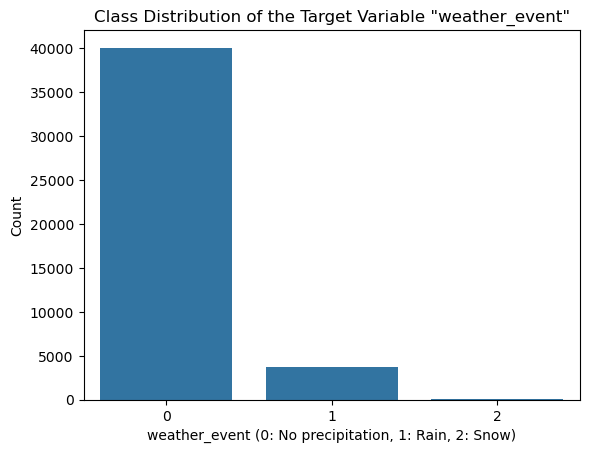

In [80]:
# Checking the class distribution of the target variable 'rain'
class_counts = lagged_1h_df['weather_event'].value_counts()
print(class_counts)

# To see the percentage distribution:
class_percentages = lagged_1h_df['weather_event'].value_counts(normalize=True) * 100
print(class_percentages)

sns.countplot(x='weather_event', data=lagged_1h_df)
plt.title('Class Distribution of the Target Variable "weather_event"')
plt.xlabel('weather_event (0: No precipitation, 1: Rain, 2: Snow)')
plt.ylabel('Count')
plt.show();

The dataset is **severely imbalanced**, with approximately 91.5% of the records representing “no precipitation" events, 8.4% for "rain" events, and only 0.1% for "snowfall" events. This class imbalance is likely to affect the model's performance, as it may become biased toward predicting the majority class (no precipitation) during training.   
To address this issue, an oversampling technique such as SMOTE (Synthetic Minority Over-sampling Technique) should be applied to ensure that the model can learn from the minority classes effectively.   
Additionally, when evaluating the model's performance, we need to focus on metrics like precision, recall and f1-score than relying on accuracy which can lead us to misleading conclusions. 
In our dataset for example, a 'dummy' model that always predicts 0, might achieve a high accuracy of 91.5%, but would completely fail in predicting rain or snowfall events, which was the purpose it was built for.

- checking for duplicated records

In [84]:
lagged_1h_df.duplicated().sum()

0

- checking for missing values

When preparing data for modeling with scikit-learn, it's crucial to ensure there are no missing (null) values, as most algorithms in scikit-learn cannot handle them. If missing values are present, the model will fail to execute. To handle this, you can use techniques like imputation (e.g., replacing missing values with the median or more advanced techniques).   
If the dataset is large enough and the missing values are minimal, removing these records can also be an option, as long as the data's <u>distributions are not distorted.</u>   
You can find useful information about missing data imputation in the **[official documentation](https://scikit-learn.org/stable/modules/impute.html)** of scikit-learn library.

In [88]:
lagged_1h_df.isna().sum()

date                              0
weather_event                     0
temperature_2m_lag_1h             0
relative_humidity_2m_lag_1h       0
dew_point_2m_lag_1h               0
surface_pressure_lag_1h           0
cloud_cover_low_lag_1h            0
cloud_cover_mid_lag_1h            0
evapotranspiration_lag_1h         0
vapour_pressure_deficit_lag_1h    0
wind_speed_10m_lag_1h             0
wind_gusts_10m_lag_1h             0
soil_temp_0_to_7cm_lag_1h         0
soil_moist_0_to_7cm_lag_1h        0
direct_radiation_lag_1h           0
month_lag_1h                      0
dtype: int64

- checking linear relations between variables using a correlation matrix heatmap

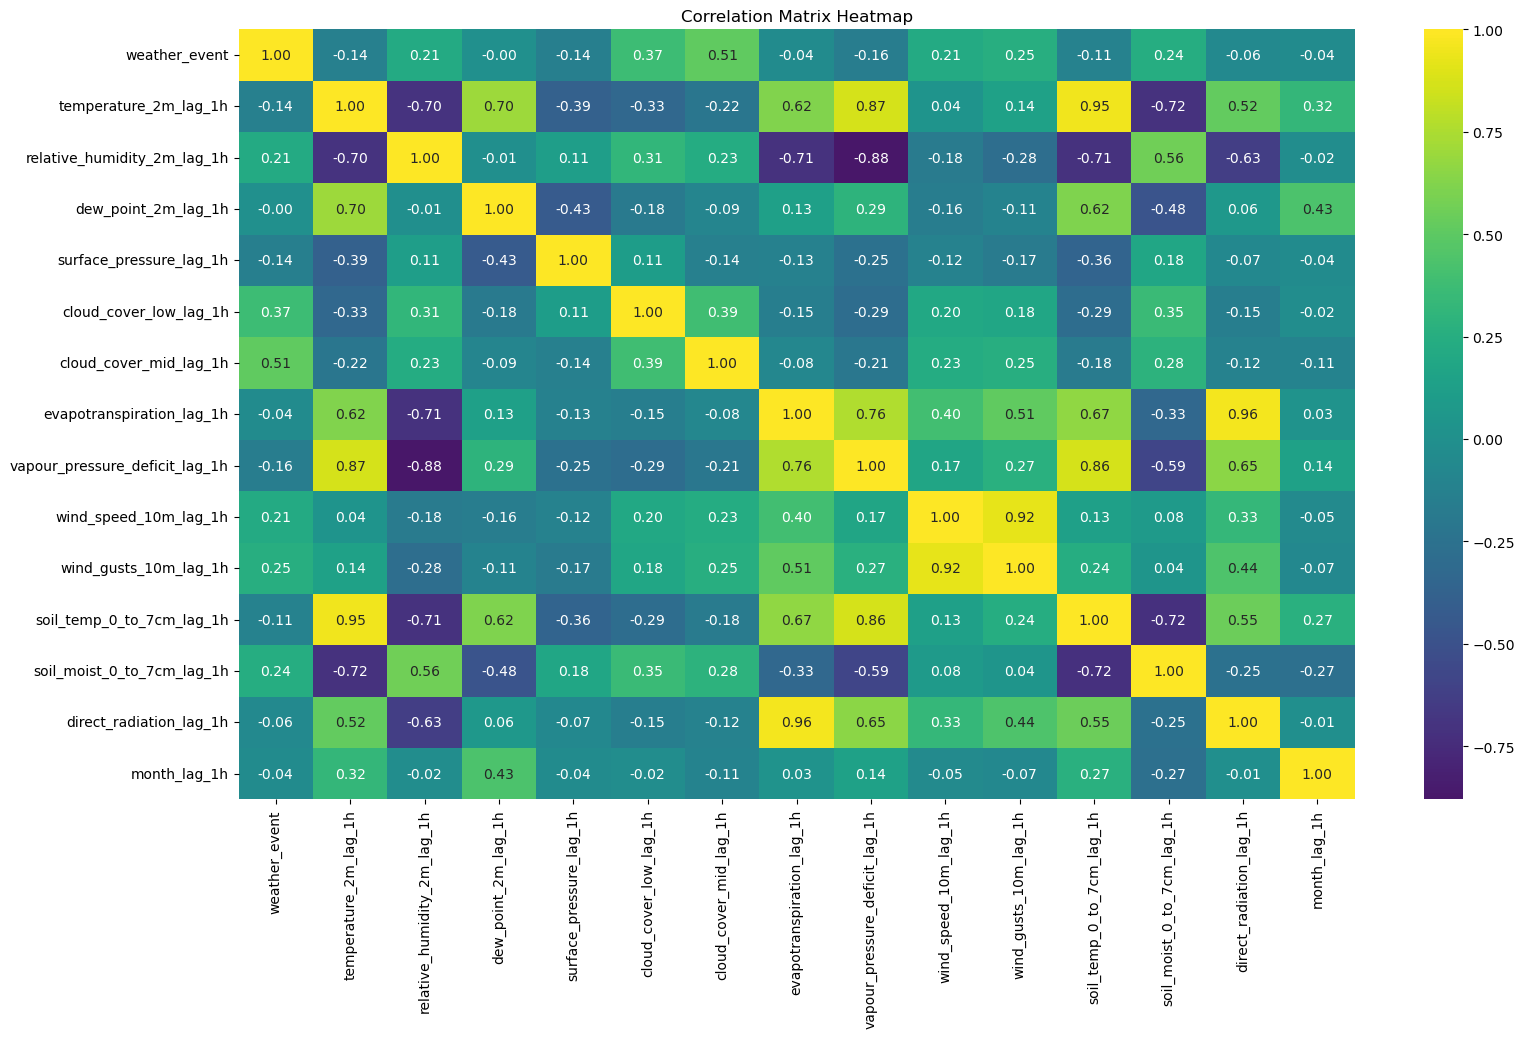

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = lagged_1h_df.corr(numeric_only = True, method = 'pearson')

# Create the heatmap
figure = plt.figure(figsize=(18, 10));
heatmap = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='viridis', center=0)

# Add a title
title = plt.title('Correlation Matrix Heatmap')

# Display the heatmap
plt.show()

There are several strong correlations among the variables, with values well above 0.75. Some pairs of variables show correlations as high as -0.88, 0.92, or even 0.96!

#### Addressing the issue of multicollinearity

One common approach when dealing with strongly correlated variables is to remove one variable from each highly correlated pair—the one that proves to be less contributive to the model's outcome.   
This can be based on the variables/features contribution to the model's performance, which can only be evaluated after modeling.   
So in this case rerunning the model is necessary to assess the impact on performance after each variable removal, making this an iterative process that requires time and patience.

An alternative approach is Principal Component Analysis (PCA), a technique used to reduce the dimensionality of the dataset and handle multicollinearity. PCA transforms correlated variables into uncorrelated principal components. However, the downside of this technique is that while it effectively addresses multicollinearity, it results in a model that is difficult to interpret. Since the transformed components do not correspond directly to the original features, and thus the concept of feature importance becomes useless in most cases.   

Feature engineering and Interaction Terms is another approach, but it definitely demands Domain knowledge and experience on this particular field, so this is not an option for us also.   

What remains as an option to handle the issue of multicollinearity is Regularization.   
Specifically, L2 Regularization (Ridge) Logistic Regression, allows us to keep all important variables, even if they are highly correlated, by shrinking their coefficients.   
This addresses multicollinearity without losing interpretability while at the same time it helps control overfitting (if any) and provides a more balanced model without removing critical features or transforming them into less interpretable forms.   
The good news is that the `LogisticRegression()` function, uses by default for the penalty argument the l2 term and therefore we will leave multicollinearity to be handled (to an extent of course) internally by the algorithm.

Therefore, we will retain all features in our dataset and tackle multicollinearity during the modeling process, where Ridge (L2) Logistic Regression will be among the methods we will apply.

- plotting predictor distributions

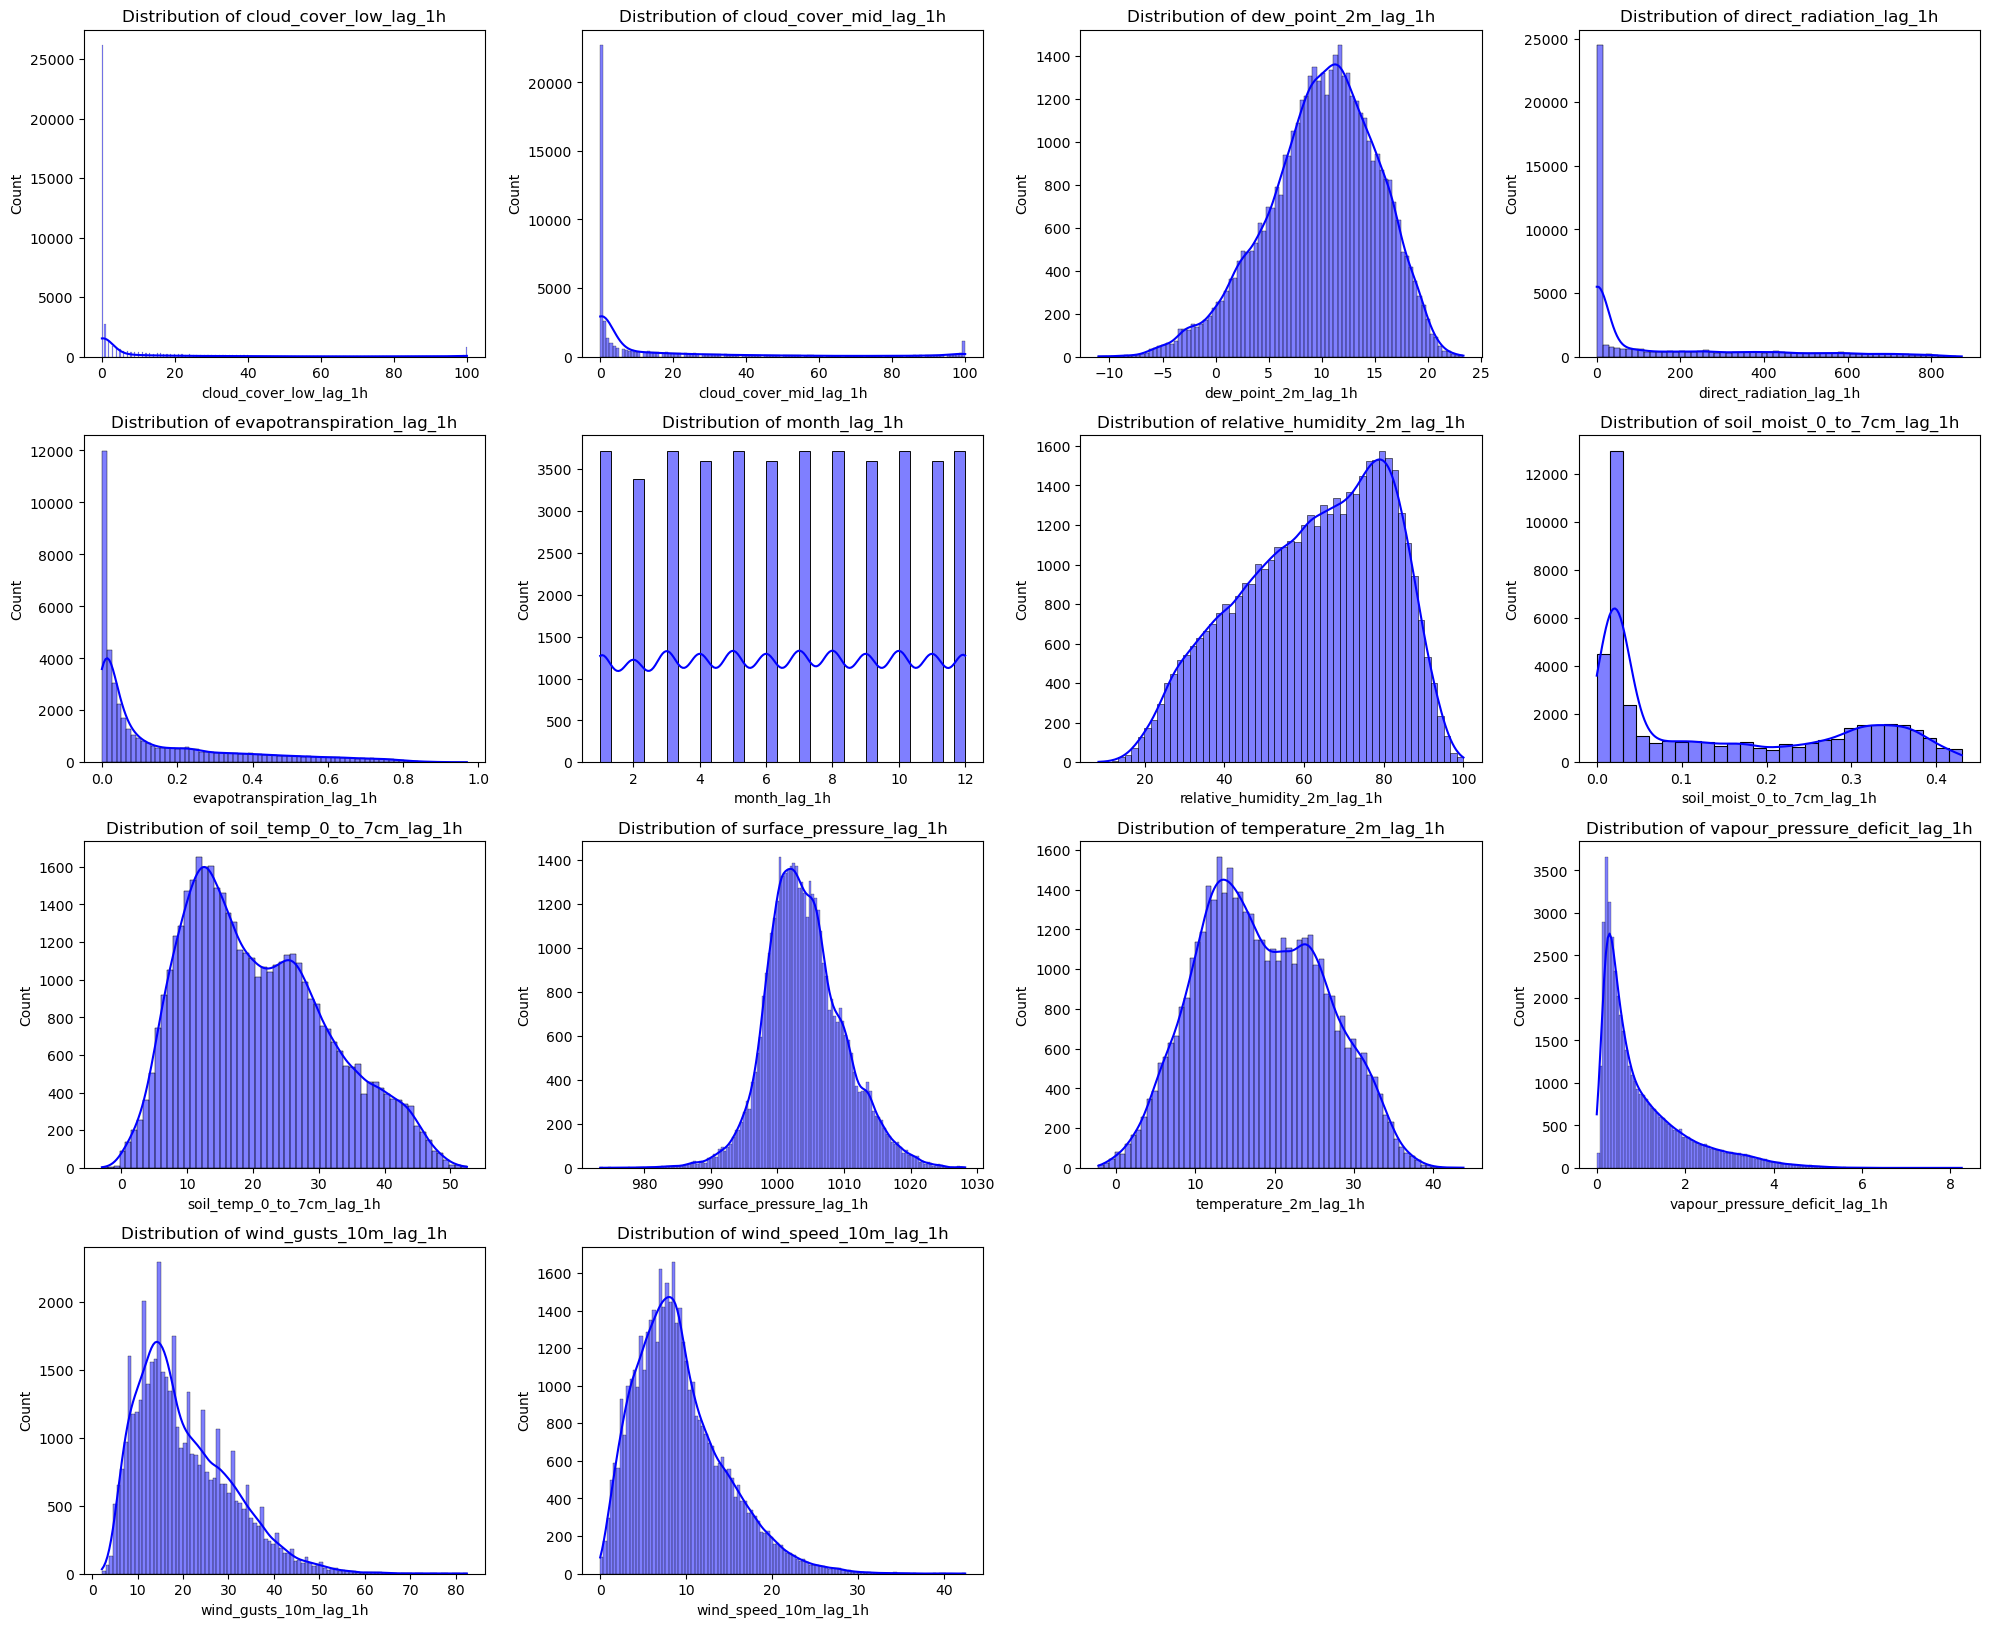

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of columns to plot
columns_to_plot = lagged_1h_df.columns.difference(['date', 'weather_event'])

# Set up the grid (3 rows x 4 columns per page)
figure = plt.figure(figsize=(20, 20))  # Adjusted for better spacing

# Loop through each column and create a distribution + boxplot below
for i, col in enumerate(columns_to_plot, start=1):
    subplot = plt.subplot(len(columns_to_plot)//3 + 1, 4, i)
    histplot = sns.histplot(lagged_1h_df[col], kde=True, color='blue')
    
    title = plt.title(f'Distribution of {col}', fontsize=12)  # Titles for each plot

plt.savefig('distributions.png', format='png', dpi=300)

# Adjust the layout for better visual spacing
layout = plt.tight_layout()
plt.show()

From the distribution plots there are several conclusions we can derive, such as:
- 'surface_pressure' and 'dew_point_2m' display more symmetrical distributions, suggesting that the values for these variables are distributed more evenly around a central point. They can be well approximated from the normal distribution and therefore easier to predict
- 'evapotranspiration' and 'vapour_pressure' are highly right-skewed. This means that most of their values are concentrated close to 0, indicating that extreme values to the right tail are rare, and most likely will be indicated as outliers
- the values in features like 'relative_humidity' and 'wind_gusts' are spread across a wider range, which could imply that these features fluctuate significantly over time
- just like spotted in the descriptive statistics table, the varying scales of some distributions (some are tightly concentrated around a single value, while others are spread out over a large range) are evident, and therefore it is crucial to use scaling methods like `RobustScaler` or `StandardScaler` before applying machine learning algorithms, to prevent certain features from dominating due to their wider range.

#### Feature Transformation

In cases where variables deviate significantly from a Gaussian distribution, particularly those with high positive skewness, it may be necessary to apply a transformation to approximate normality.   

Many machine learning models and statistical techniques assume normality, as variables with a Gaussian-like distribution can lead but not guarantee better model performance and more reliable inferences. The Yeo-Johnson transformation is one such method, particularly useful for handling variables that include zero or negative values. Unlike the logarithmic and square root transformations, which are constrained to non-negative values, Yeo-Johnson can accommodate a broader range of data.   

However, the effectiveness of this or any transformation is not guaranteed, and it may or may not improve the model's performance. The process is iterative: you apply the transformation, evaluate the results, and reassess as needed.

In [94]:
from scipy.stats import skew

# Apply skew only to numeric columns
numeric_cols = lagged_1h_df.select_dtypes(include=['float64'])

# Identify skewed features
skewed_features = numeric_cols.columns[numeric_cols.apply(lambda x: skew(x.dropna())) > 0.5]

In [96]:
skewed_features

Index(['cloud_cover_low_lag_1h', 'cloud_cover_mid_lag_1h',
       'evapotranspiration_lag_1h', 'vapour_pressure_deficit_lag_1h',
       'wind_speed_10m_lag_1h', 'wind_gusts_10m_lag_1h',
       'soil_moist_0_to_7cm_lag_1h', 'direct_radiation_lag_1h'],
      dtype='object')

In [98]:
skew(lagged_1h_df[skewed_features])

array([2.67956222, 2.08758382, 1.47654365, 1.60329461, 0.93330621,
       0.91918281, 0.54161698, 1.43214601])

In [100]:
# Apply Yeo-Johnson transformation to skewed features
from sklearn.preprocessing import PowerTransformer
transformer = PowerTransformer(method='yeo-johnson')
lagged_1h_df[skewed_features] = transformer.fit_transform(lagged_1h_df[skewed_features])  

In [102]:
lagged_1h_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43823 entries, 1 to 43823
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   date                            43823 non-null  object 
 1   weather_event                   43823 non-null  int64  
 2   temperature_2m_lag_1h           43823 non-null  float64
 3   relative_humidity_2m_lag_1h     43823 non-null  float64
 4   dew_point_2m_lag_1h             43823 non-null  float64
 5   surface_pressure_lag_1h         43823 non-null  float64
 6   cloud_cover_low_lag_1h          43823 non-null  float64
 7   cloud_cover_mid_lag_1h          43823 non-null  float64
 8   evapotranspiration_lag_1h       43823 non-null  float64
 9   vapour_pressure_deficit_lag_1h  43823 non-null  float64
 10  wind_speed_10m_lag_1h           43823 non-null  float64
 11  wind_gusts_10m_lag_1h           43823 non-null  float64
 12  soil_temp_0_to_7cm_lag_1h       43823

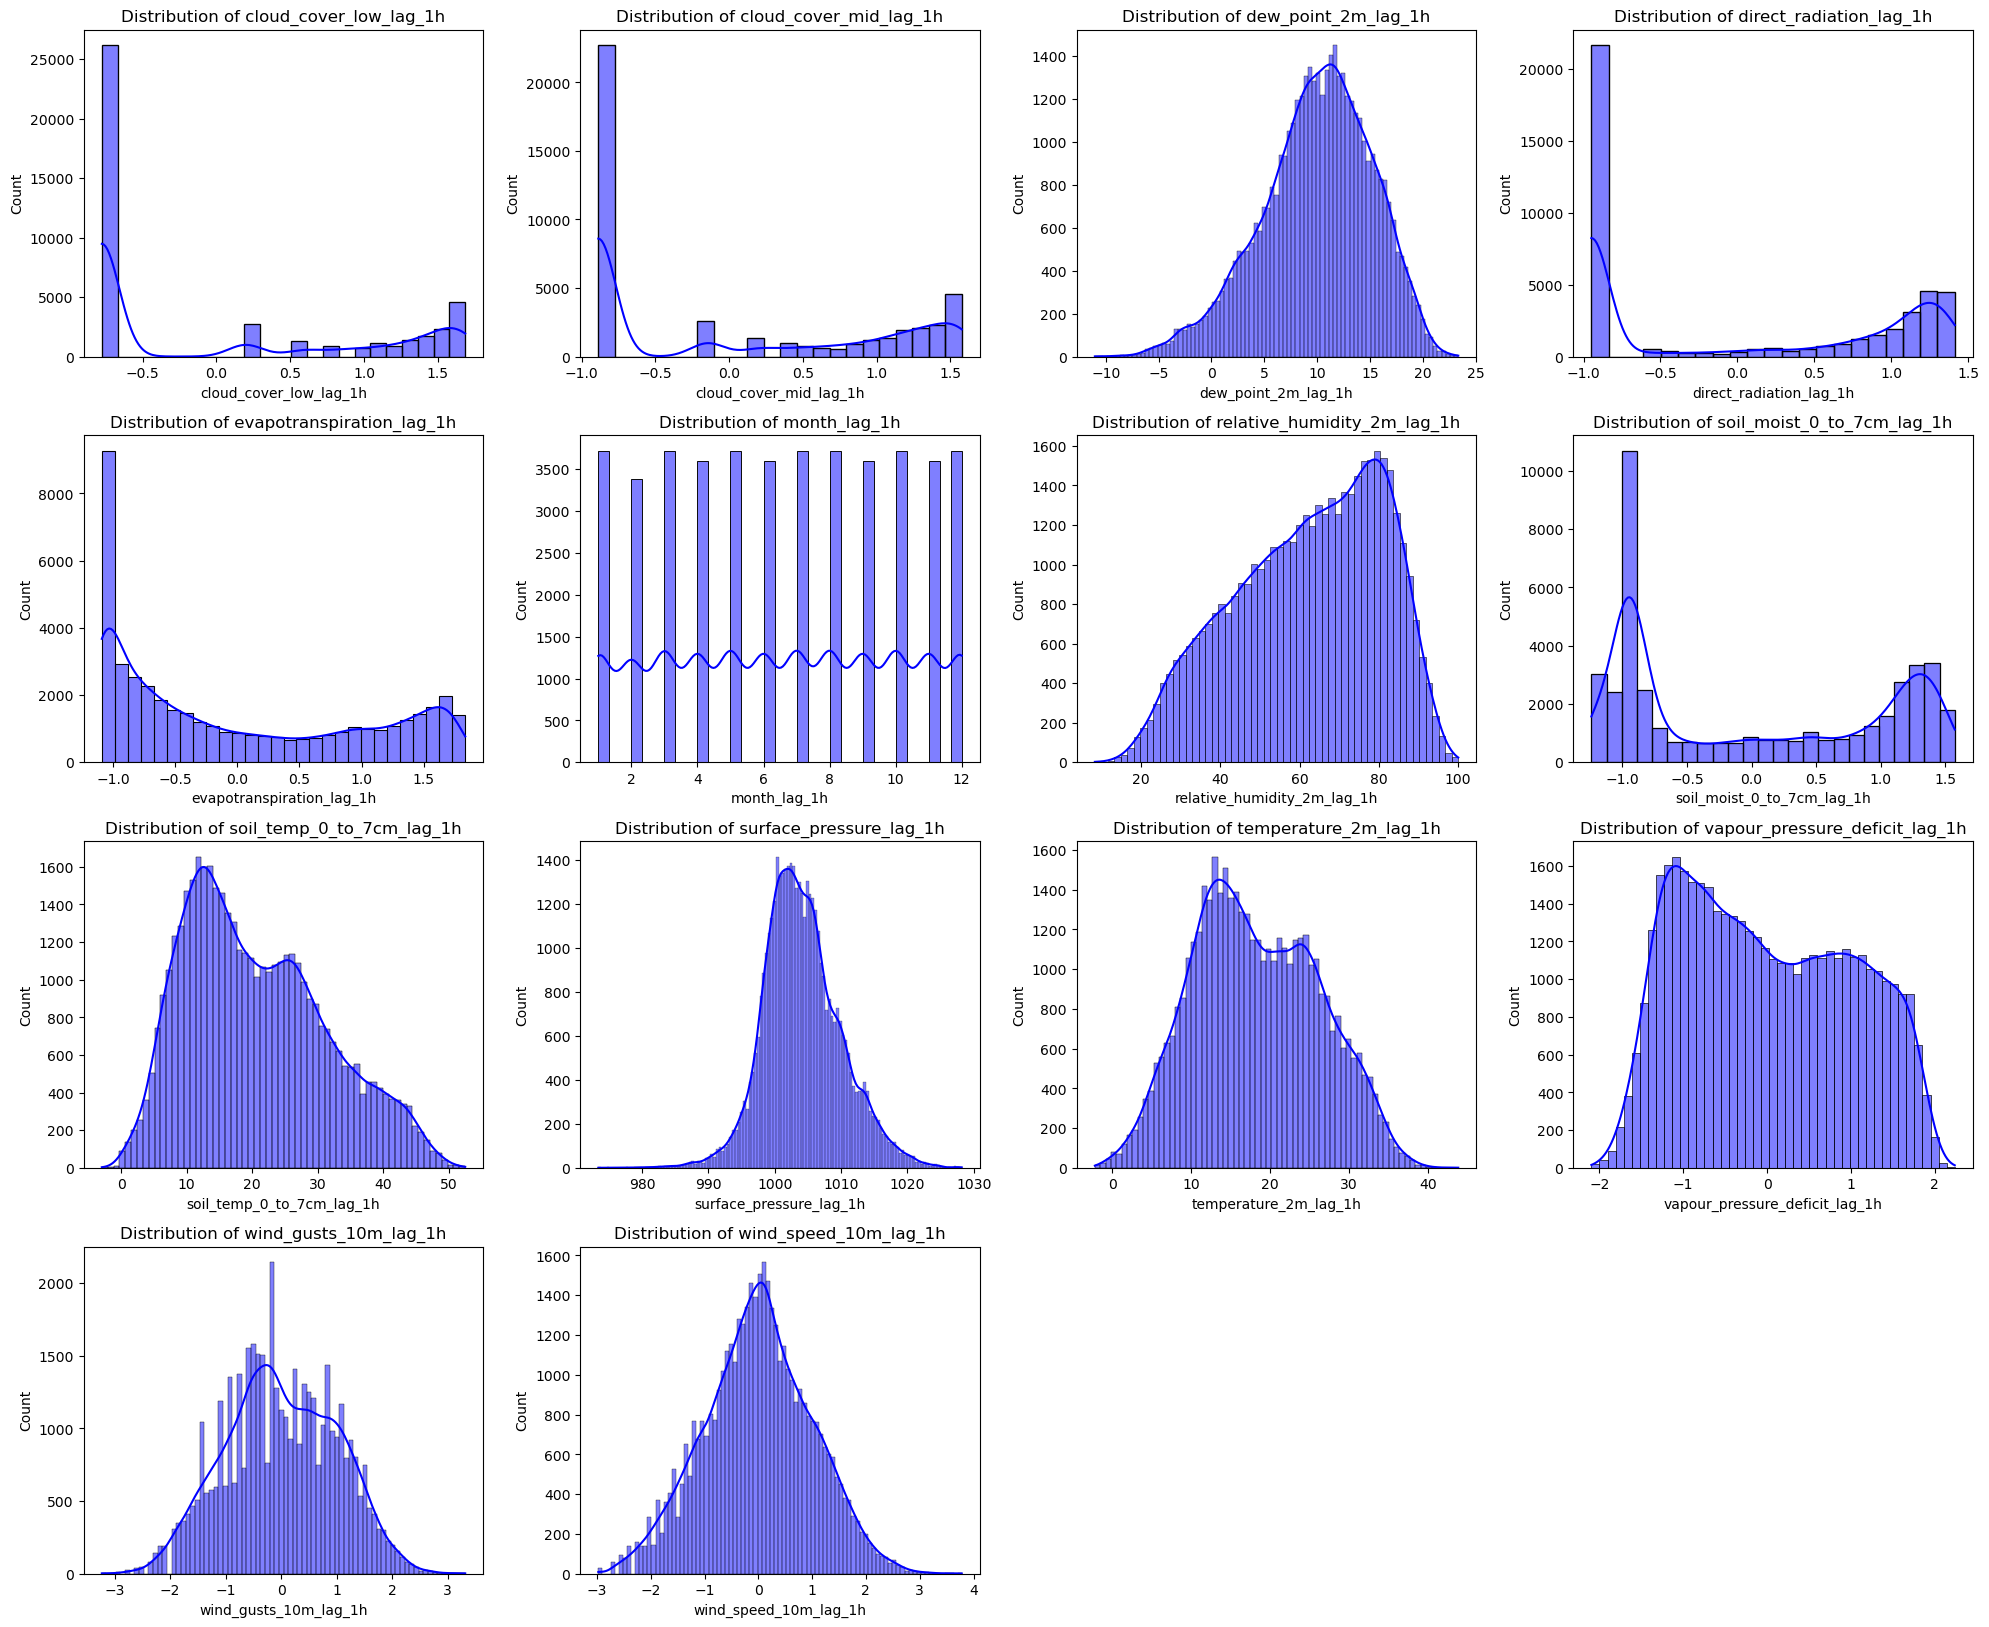

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of columns to plot
columns_to_plot = lagged_1h_df.columns.difference(['date', 'weather_event'])

# Set up the grid (3 rows x 4 columns per page)
figure = plt.figure(figsize=(20, 20))  # Adjusted for better spacing

# Loop through each column and create a distribution + boxplot below
for i, col in enumerate(columns_to_plot, start=1):
    subplot = plt.subplot(len(columns_to_plot)//3 + 1, 4, i)
    histplot = sns.histplot(lagged_1h_df[col], kde=True, color='blue')
    
    title = plt.title(f'Distribution of {col}', fontsize=12)  # Titles for each plot

plt.savefig('distributions.png', format='png', dpi=300)

# Adjust the layout for better visual spacing
layout = plt.tight_layout()
plt.show()

The Yeo-Johnson transformation worked effectively for some variables, particularly `wind_gusts_10m_lag_1h` and `wind_speed_10m_lag_1h`, showing a better approximation to normality. However, for other variables, the transformation proved less effective in approximating a Gaussian distribution.

With the exception of the unweighted standard approach, you will notice a slight improvement in minority class performance, with an increase in True Positives (TPs) and a reduction in both False Positives (FPs) and False Negatives (FNs), though without significantly affecting the overall model performance.

Nevertheless, for this project, we will continue with the Yeo-Johnson transformation.

- exploring predictor variable distributions across target classes

It is essential to check how predictor variables behave across different classes of the target variable. This step allows us to identify patterns and understand the relationship between predictors and the target classes (no precipitation, rain, snowfall).   
Detecting any significant variation (shape and value counts across classes) in distributions might indicate that a variable could be an important predictor for the occurrence of a class, while similar distributions across classes could suggest a variable with less predictive power.

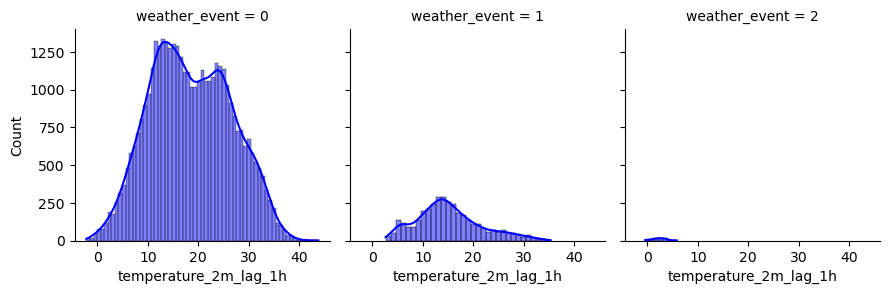

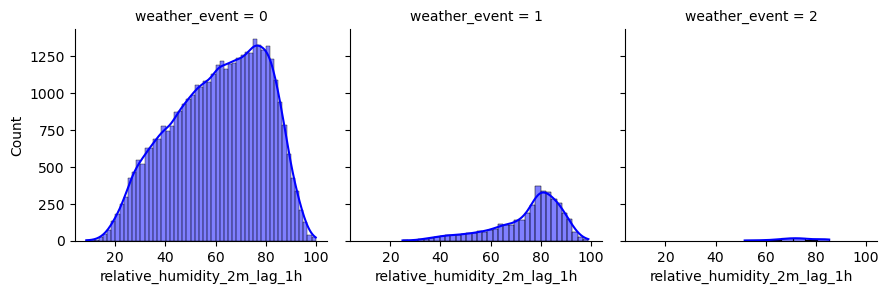

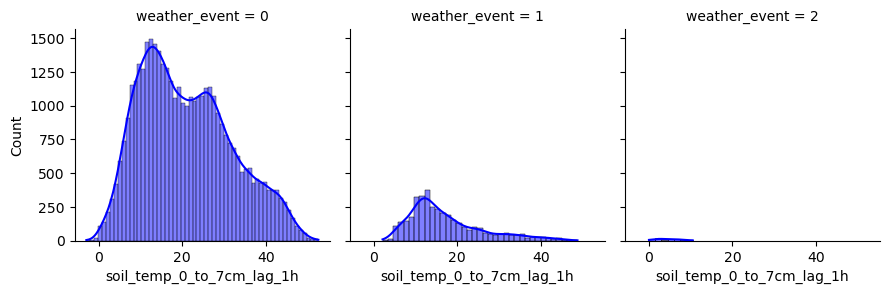

In [109]:
# Set the color palette for consistency
sns.set_palette('husl')

# Create FacetGrid for temperature and relative humidity in separate rows
g1 = sns.FacetGrid(lagged_1h_df, col="weather_event", col_wrap=3, height=3)
map1 = g1.map(sns.histplot, "temperature_2m_lag_1h", kde=True, color="blue")  
subplot1 = g1.fig.subplots_adjust(top=0.9)  

g2 = sns.FacetGrid(lagged_1h_df, col="weather_event", col_wrap=3, height=3)
map2 = g2.map(sns.histplot, "relative_humidity_2m_lag_1h", kde=True, color="blue")  
subplot2 = g2.fig.subplots_adjust(top=0.9) 

g3 = sns.FacetGrid(lagged_1h_df, col="weather_event", col_wrap=3, height=3)
map3 = g3.map(sns.histplot, "soil_temp_0_to_7cm_lag_1h", kde=True, color="blue")  
subplot3 = g3.fig.subplots_adjust(top=0.9) 

plt.show()

- detecting outliers

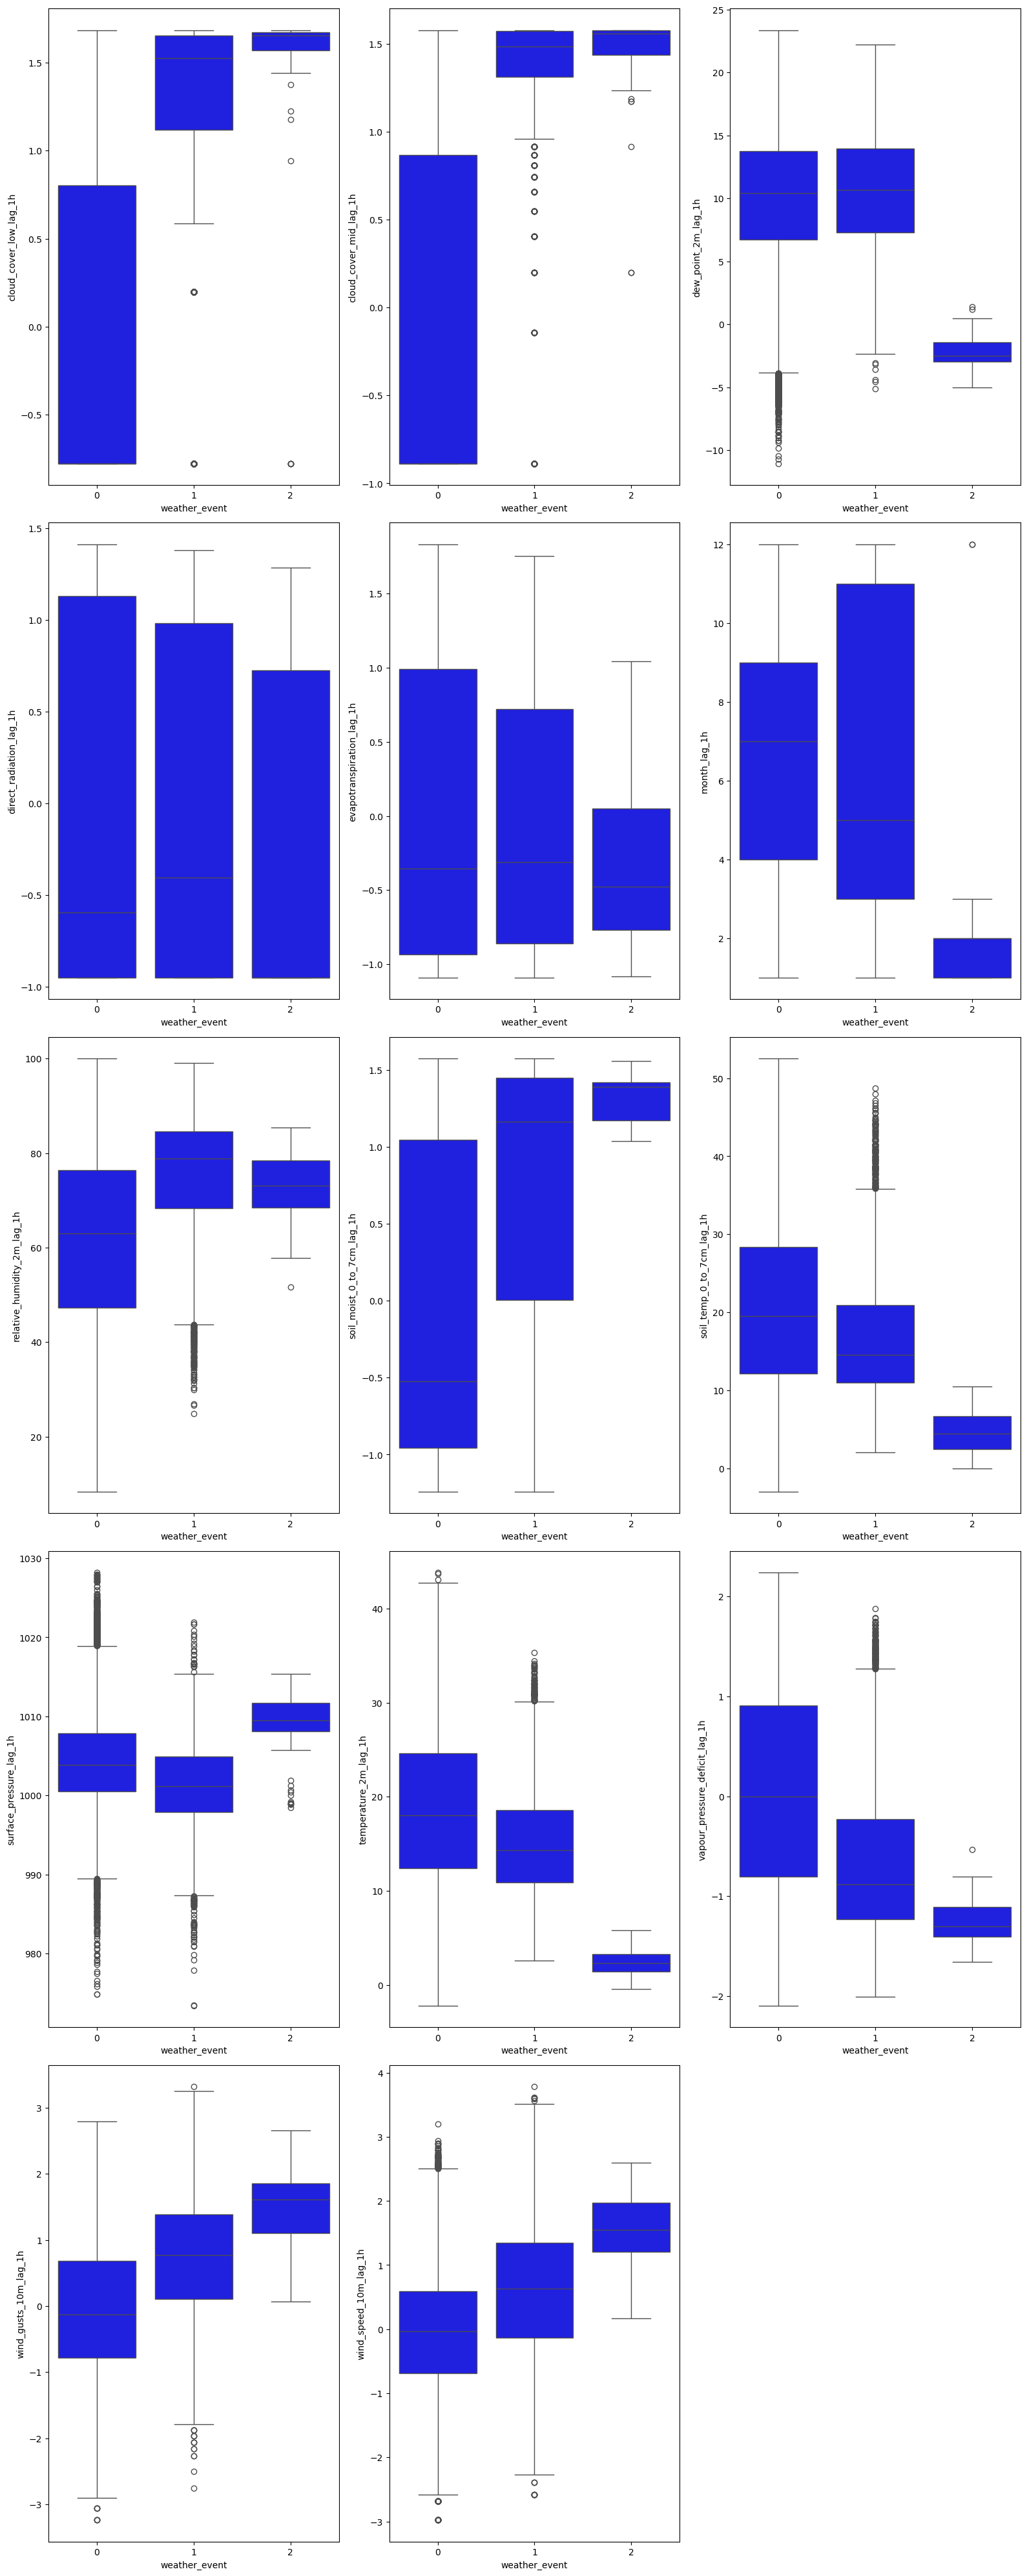

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style for a cleaner look
palette = sns.set_palette('husl')

# List of columns to plot
columns_to_plot = lagged_1h_df.columns.difference(['date', 'weather_event'])

# Set up the grid for 3 columns x 5 rows per page (adjust based on total variables)
figure = plt.figure(figsize=(16, 40))

# Loop through each column and create a boxplot with weather_event grouping
for i, col in enumerate(columns_to_plot, start=1):
    subplot = plt.subplot(len(columns_to_plot)//3 + 1, 3, i)  # Define a 3-column layout
    boxplot = sns.boxplot(data=lagged_1h_df, x='weather_event', y=col, color='blue')  # Grouped by weather_event

# Adjust the layout
layout = plt.tight_layout()
plt.show()

Viewing the above box plots makes the presence of outliers is evident to a significant extent, despite the fact that a step earlier we transformed the variables in an attempt to approximate normality.   
Whether these values represent erroneous data or actual/true records is uncertain.   

With the **lack of fundamental domain knowledge**, access to the instruments used for the measurements, or the procedures followed, makes any kind of inference on the outliers impossible.   

For this reason, it is better to retain all records, since even a simple action like removing the outliers will likely distort the distributions and alter the model's performance.

## Modeling process

During modeling phase the metric that will be used to evaluate the performance of the models as well as to facilitate the comparison between them is `balanced accuracy`.  

Balanced accuracy is the average of the recall (sensitivity) for each class, treating each class equally regardless of its frequency.   
Unlike standard accuracy, which in imbalanced datasets is biased towards the majority class and gives a false impression about the model's performance, balanced accuracy metric provides a clearer view of how well the model performs across all classes and illustrate the overall model performance.

For a heavily imbalanced dataset, balanced accuracy will prevent the majority class from dominating the metric, allowing us to see if the model truly performs well on the minority classes, and not only on the majority class.

You can find detailed information on evaluation metrics used for both classification and regression tasks in the **[official documentation](https://scikit-learn.org/1.5/modules/model_evaluation.html)**

### Logistic Regression Essentials

Multinomial Logistic Regression is a classification algorithm used when the target variable is categorical and has more than two possible classes.   
Unlike binary logistic regression, which uses the sigmoid function, multinomial logistic regression uses the softmax function to predict the probability of each class.
How the Algorithm Works:

**Input Features and Coefficients:**   
The model takes the input features (independent variables, X) and initializes a vector of coefficients (θ) for each class.   
These coefficients are initially set to small random values or zeros and will be adjusted during the training process by the solver (the optimization algorithm). 

**Logit Calculation:**   
For each class k, the logit is computed as a linear combination of the input features and their corresponding coefficients:   
    $$
   \text{logit}_k = \theta_{0,k} + \theta_{1,k} x_1 + \theta_{2,k} x_2 + \dots + \theta_{n,k} x_n
    $$

The model calculates a logit for each class, and this is the raw score before probabilities are computed. Applying this and you end up in our project with 3 logits for every record in your dataset. (1 logit for the 'no precipitation class/label, 1 logit for the 'rain' class/label and 1 logit for the 'snowfall' class/label) 

**Softmax Transformation:**   
The logits are then passed through the softmax function, which converts them into probabilities for each class.   
The softmax function also ensures that all probabilities are between 0 and 1, and that the total probability across all classes equals 1:   
    $$
   P(y = k \mid X) = \frac{\exp(\text{logit}_k)}{\sum_{j=1}^{K} \exp(\text{logit}_j)}
    $$
So after the Softmax transformation every record in the dataset has been assigned with a probability for each class.   
In our case the model predicts whether there will be 'No Precipitation', 'Rain', or 'Snowfall', and it calculates three logits (one for each class). These logits are then transformed into probabilities using the softmax function and the model assigns the class with the highest probability to the target variable y.   
For example, a record in our dataset could end up having the following probabilities:
   - No Precipitation: 0.60   
   - Rain: 0.30   
   - Snowfall: 0.10
   
Then the model would predict the class 'No Precipitation' for the target variable y, since it has the highest probability.

**Loss/Error Function (Cross-Entropy):**   

The cross-entropy loss function measures the error between the predicted probabilities and the true class labels. It’s calculated as:   
    $$
   L = - \sum_{k=1}^{K} y_k \log \left( P(y = k \mid X) \right)
    $$   

This loss is used as feedback to the model. The closer the predicted probability is to the true label, the smaller the loss.   
To make it more concrete we will use the above example where the model predicted 'No precipitation' and suppose that the true label was 'rain'.   
In this example, since the true label is Rain, we have $y_{\text{rain}}=1$, and for the other classes, $y_{\text{no precipitation}}=0$ and $y_{\text{snowfall}}=0$.   

Applying the formula of the loss function shown above, and considering only the probability for the correct class (Rain), as the other terms will be multiplied by 0, we have: $L = -(1 \times \log(0.30)) - (0 \times \log(0.60)) - (0 \times \log(0.10))$ which leads to:   $L = -\log(0.30) \approx -(-0.523) = 0.523$.   
This is the loss for this particular record (0.523).


At this point the solver takes charge and adjusts the coefficients in the direction to minimize the loss function.

**Solver and Coefficient Adjustment:**   
The solver is the optimization algorithm responsible for adjusting the θ vectors (the coefficients). It iteratively updates the coefficients to reduce the loss, stopping when the change in the loss function between iterations falls below a certain threshold (tol) or after a maximum number of iterations (max_iter) is reached.

All the above come into place in the scikit-learn library where the model/algorithm is implemented. You can find all the details you may need in the official documentation of the library **[here](https://scikit-learn.org/stable/)**




### Standard Logistic Regression

We will begin the modeling phase by initializing a Logistic Regression model with default settings, without any adjustments for class imbalance. This model will serve as our baseline, providing a reference point against which, we can compare other potentially more complex or adjusted models and offer a straightforward and intuitive way to compare different model implementations.

- separate the dataset into input space X (the predictor variables) and to output space y (the target/response) variable

In [114]:
X = lagged_1h_df.drop(columns=['date', 'weather_event'])
y = lagged_1h_df['weather_event']

- data is split into a training set (70%) and a test set (30%) using stratified sampling to maintain the proportions of the target variable y in both sets. This ensures that the model is trained and evaluated with the same label distribution. The random state is set for reproducibility.

In [117]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=2024)

- earlier, we emphasized the necessity of scaling due to the varying ranges of the predictors and the presence of outliers. To handle this, we apply RobustScaler(), which is more robust to outliers compared to other scaling methods

In [120]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

- initialize the Standard Logistic Regression model. Set the `multi_class` argument to 'multinomial' for multiclass classification, and the `random_state` argument to make the process reproducible.

In [123]:
from sklearn.linear_model import LogisticRegression
logreg_standard = LogisticRegression(multi_class='multinomial', random_state=2024, solver='saga', max_iter=5000, n_jobs=-1)

- fitting the training data into the model we initialized in the previous step in order to train it

In [126]:
import time
start = time.time()

logreg_standard.fit(X_train_scaled, y_train)

print(f"Execution time: {time.time() - start}")
print(f"Number of iterations: {logreg_standard.n_iter_[0]}")
print('\n')

LogisticRegression(max_iter=5000, multi_class='multinomial', n_jobs=-1,
                   random_state=2024, solver='saga')

Execution time: 2.170510768890381
Number of iterations: 234




- extracting the predicted values of y by passing the test set features (X_test) into the trained model

In [129]:
y_pred_standard = logreg_standard.predict(X_test_scaled)

#### Model Evaluation

- Setting up a 10-fold cross-validation with stratified sampling to ensure that each fold has the same proportion of classes as the original dataset. Setting the random state to ensure reproducibility. This stratified cross-validation will be used to evaluate the model's performance on the training set before evaluating it on the unseen test set.

In [133]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
stkf = StratifiedKFold(n_splits=10, shuffle=True, random_state=2024)

- apply the model on the 10 folds created on the previous step and computing the metric of our choice (balanced_accuracy) for each of the 10 folds. Printing the mean of the metric value across all folds along with its standard deviation.

In [136]:
logreg_standard_cv = cross_val_score(logreg_standard, X_train_scaled, y_train, cv=stkf, scoring="balanced_accuracy", n_jobs=-1)
print(logreg_standard_cv)
print(f'\nThe mean value of balanced_accuracy on the evaluation of the train set is {logreg_standard_cv.mean().round(3)}')
print(f'\nThe standard deviation of balanced_accuracy on the evaluation of the train set is {logreg_standard_cv.std().round(3)}')

[0.57763127 0.47127971 0.5601973  0.47338203 0.61930974 0.59927023
 0.55009208 0.58216112 0.47680222 0.56000152]

The mean value of balanced_accuracy on the evaluation of the train set is 0.547

The standard deviation of balanced_accuracy on the evaluation of the train set is 0.052


- Generating the confusion matrix to visualize the performance of the model on the test set this time. The confusion matrix shows how well the model predicted each class by displaying the true positive, false positive, true negative, and false negative counts for each class ('No Precipitation', 'Rain', 'Snowfall').

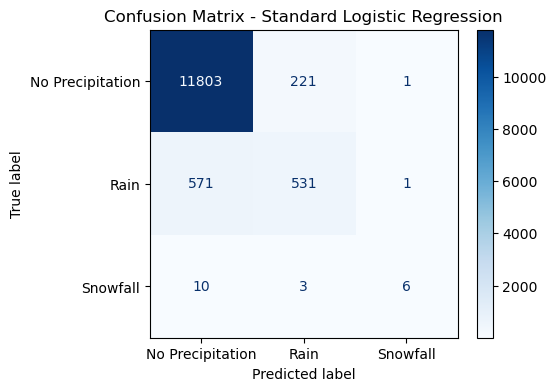

In [139]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
conf_matrix_standard = confusion_matrix(y_test, y_pred_standard)
fig, ax = plt.subplots(figsize=(5, 4))
disp = ConfusionMatrixDisplay(conf_matrix_standard, display_labels=['No Precipitation', 'Rain', 'Snowfall'])
plot = disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
title = plt.title('Confusion Matrix - Standard Logistic Regression')
plt.show()

At this point, it's important to mention that the severe imbalance in the target variable's classes significantly impacted the model's performance, as seen in the confusion matrix above. The model performed well in predicting instances of the majority class ('No Precipitation'), correctly identifying 11803 out of a total of 12025 instances. However, when it came to the minority classes, the model struggled. For 'Rain' events, it correctly predicted only about half of the instances (531 out of 1,103), and for the 'Snowfall' class, the model captured just 6 out of 19 events.   
This is a common challenge in classification tasks when dealing with imbalanced datasets, where the model tends to favor the majority class at the expense of the minority classes.

- next step in evaluating the model’s performance on the test set is to compute the Precision-Recall curve for each class (No Precipitation, Rain, Snowfall) based on the model’s predicted probabilities. The precision-recall curve illustrates the trade-off between precision and recall across different probability thresholds. This metric is very important when evaluating models on heavily imbalanced datasets like ours. It shows that for the minority classes, increasing true positive predictions (recall) usually leads to a drop in precision, as false positive predictions increase. In the plot below, you can see that as recall approaches 1, precision tends to decrease towards 0, emphasizing the trade-off between these metrics.

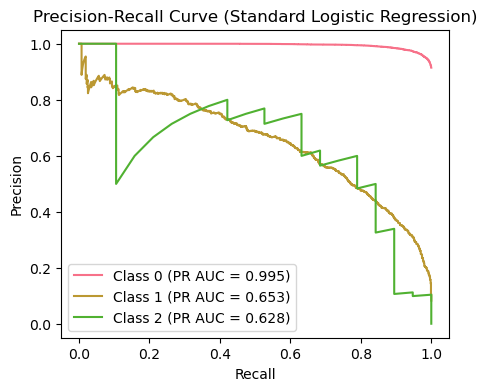

In [143]:
from sklearn.metrics import precision_recall_curve, auc
y_pred_probs_standard = logreg_standard.predict_proba(X_test_scaled)
figure = plt.figure(figsize=(5, 4)) 
for i in range(3):  
    precision, recall, _ = precision_recall_curve(y_test == i, y_pred_probs_standard[:, i])
    pr_auc = auc(recall, precision)
    
    # Plot the precision-recall curve
    plot = plt.plot(recall, precision, label=f'Class {i} (PR AUC = {pr_auc:.3f})')

xlabel = plt.xlabel('Recall')
ylabel = plt.ylabel('Precision')
title = plt.title('Precision-Recall Curve (Standard Logistic Regression)')
legend = plt.legend()
plt.show()

- last step on the evaluation of the model is to create a classification report, summarizing the key metrics for each class: precision, recall, F1-score, and PR AUC (Precision-Recall Area Under the Curve). The classification report provides a detailed breakdown of these metrics for each class (No Precipitation, Rain, and Snowfall), which helps to evaluate how well the model performs for each category. Additionally, we calculate and include overall metrics such as balanced_accuracy, which is more suitable for the imbalanced nature of the dataset against the simple accuracy metric, and f1_weighted, which takes into account the number of instances in each class to give a more balanced overall F1-score. Lastly, pr_auc_weighted aggregates the PR AUC score across all classes, giving a more holistic view of the model’s performance. We transformed the report to a 1-row dataframe so as to make future comparisons with other models easier.

In [146]:
from sklearn.metrics import classification_report, balanced_accuracy_score, f1_score, average_precision_score

report_dict_standard = classification_report(y_test, y_pred_standard, digits=3, output_dict=True)

# Calculate PR AUC for each class
precision_0, recall_0, _ = precision_recall_curve(y_test == 0, y_pred_probs_standard[:, 0])
pr_auc_0 = auc(recall_0, precision_0)

precision_rain, recall_rain, _ = precision_recall_curve(y_test == 1, y_pred_probs_standard[:, 1])
pr_auc_rain = auc(recall_rain, precision_rain)

precision_snow, recall_snow, _ = precision_recall_curve(y_test == 2, y_pred_probs_standard[:, 2])
pr_auc_snow = auc(recall_snow, precision_snow)

# Create a single row dataframe with the required metrics
report_df_standard = pd.DataFrame({
    'precision_0': [report_dict_standard['0']['precision']],
    'recall_0': [report_dict_standard['0']['recall']],
    'f1_0': [report_dict_standard['0']['f1-score']],
    'pr_auc_0': [pr_auc_0],
    
    'precision_rain': [report_dict_standard['1']['precision']],
    'recall_rain': [report_dict_standard['1']['recall']],
    'f1_rain': [report_dict_standard['1']['f1-score']],
    'pr_auc_rain': [pr_auc_rain],
    
    'precision_snow': [report_dict_standard['2']['precision']],
    'recall_snow': [report_dict_standard['2']['recall']],
    'f1_snow': [report_dict_standard['2']['f1-score']],
    'pr_auc_snow': [pr_auc_snow],
    'balanced_accuracy': [balanced_accuracy_score(y_test, y_pred_standard)],
    'f1_weighted': [f1_score(y_test, y_pred_standard, average='weighted')],
    'pr_auc_weighted': [average_precision_score(y_test, y_pred_probs_standard, average='weighted')]
})

print('Standard Logistic Regression')
report_df_standard

Standard Logistic Regression


,precision_0,recall_0,f1_0,pr_auc_0,precision_rain,recall_rain,f1_rain,pr_auc_rain,precision_snow,recall_snow,f1_snow,pr_auc_snow,balanced_accuracy,f1_weighted,pr_auc_weighted
0,0.953085,0.981538,0.967102,0.994943,0.703311,0.481414,0.571582,0.653215,0.75,0.315789,0.444444,0.628211,0.592914,0.933164,0.965786


#### Plotting the learning curve

Before exploring the learning curve to gain insights into a model's performance, we must first understand what the curve represents.

A learning curve shows a model's performance with respect to a performance metric (in our case, balanced accuracy) as a function of the training set size (number of records). It visualizes how well the model learns patterns as the dataset increases in size, helping us understand if the model has learned from the data effectively or if there are issues like underfitting or overfitting.

Each point on the curve represents the average performance (from cross-validation) for a particular training size, providing an estimate of how well the model performs at that specific data volume. This helps us see if the model’s performance improves, deteriorates, or plateaus as we feed more data into the model.

In the plot, we have two curves: one (yellow) represents the average metric score on the training dataset, and the other (purple) represents the average metric score on the validation/test dataset.   
- If both curves are low relative to the y-axis and close to each other, the model may not be complex enough to capture data patterns and is likely underfitting.
- If the training curve is high but the validation curve is low, the model might be memorizing the training data without generalizing well, indicating overfitting.
- If both curves converge at a high level, the model is likely performing well and generalizing effectively.

It is also important to observe whether the curves increase, plateau, or fluctuate as more data is fed to the model, as this indicates how additional data impacts performance.

Finally, you shouldn’t expect the performance metric on the test set (in our case balanced accuracy) from stratified cross-validation on the full dataset to exactly match the final point on the learning curve. Due to data randomness and differences in train-validation splits, the training and validation sets in the final point of the learning curve may differ from those used in cross-validation on the full dataset, leading to slight variations in metric results. The learning curve’s final point represents the average of cross-validated scores across multiple folds, while the test set score is a single evaluation on a fixed data split.

However, if the difference between the two metrics is significant, it’s worth investigating further. Potential issues could include model instability due to high complexity, overfitting to specific patterns in the data and more.

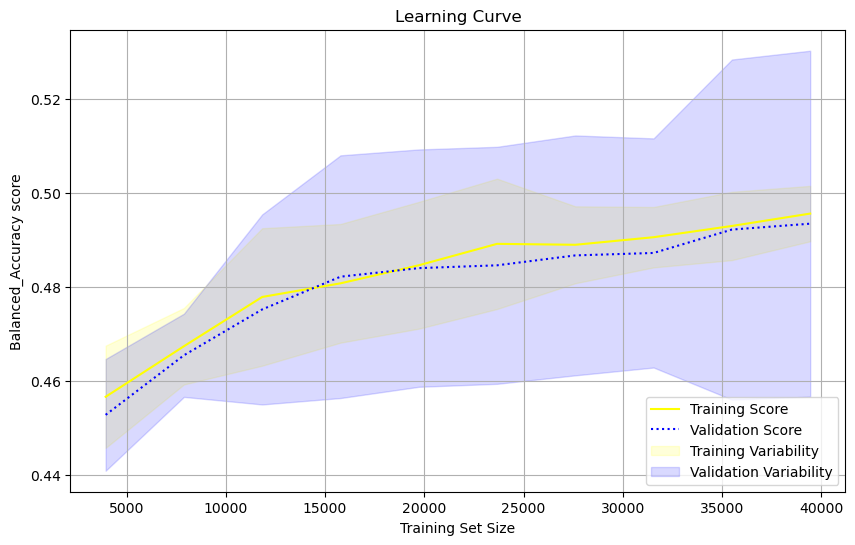

In [155]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(
    logreg_standard, X, y, cv=stkf, scoring='balanced_accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, random_state=2024
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

figure = plt.figure(figsize=(10, 6))
plot1 = plt.plot(train_sizes, train_mean, label='Training Score', color='yellow')
plot2 = plt.plot(train_sizes, test_mean, label='Validation Score', color='blue', linestyle=':')
ce1_fill = plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='yellow', alpha=0.15, label='Training Variability')
ce2_fill = plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='blue', alpha=0.15, label='Validation Variability')

xlabel = plt.xlabel('Training Set Size')
ylabel = plt.ylabel('Balanced_Accuracy score')
titel = plt.title('Learning Curve')
legend = plt.legend(loc='lower right')
grid = plt.grid(True)
plt.show()

<u>Inferences from the Learning Curve Plot</u>   

As the dataset size increases, the training and validation scores converge. Both scores stabilize around a balanced accuracy of ~0.50, and adding more data does not seem to improve them; instead, both remain relatively flat. This highlights the model's limited learning capacity and suggests high bias, as the model is struggling—likely due to the heavy class imbalance. The variance on the training set remains relatively low throughout the plot (across the full range of dataset sizes), while the variance in the validation score increases (the confidence interval of the validation score widens—the purple area) as more records are added to the dataset.

The combination of high bias and widening variance in the validation score leads us to conclude that the model is too simplistic to capture the data's patterns and distinguish the classes effectively. In fact, it appears to underfit and performs only slightly better than a random classifier. This is why we will use it as our baseline, upon which we will build, seeking models that handle class imbalance and yield better performance.

### Weighted Logistic Regression

The issue of severe class imbalance in the target variable was evident during the EDA process and became even more pronounced when we applied the Standard Logistic Regression model with the classes of the target variable unbalanced. In this section, we will explore another variant of Logistic Regression called Weighted Logistic Regression.   
As the name suggests, this variant handles the issue of class imbalance by adjusting the model to account for the uneven distribution of classes, potentially improving performance on minority classes.   
The modeling process remains the same as in the Standard Logistic Regression implementation, with one key difference: during model initialization, we set the class_weight argument to `balanced`.   
In 'balanced' mode, the algorithm automatically adjusts class weights inversely proportional to class frequencies in the input data.   
For more details on LogisticRegression and its variants, you can refer to the [official documentation](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html).


- separate the dataset into input space X (the predictor variables) and to output space y (the target/response) variable

In [158]:
X = lagged_1h_df.drop(columns=['date', 'weather_event'])
y = lagged_1h_df['weather_event']

- data is split into a training set (70%) and a test set (30%) using stratified sampling to maintain the proportions of the target variable y in both sets. This ensures that the model is trained and evaluated with the same label distribution. The random state is set for reproducibility.

In [161]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=2024)

- earlier, we emphasized the necessity of scaling due to the varying ranges of the predictors and the presence of outliers. To handle this, we apply RobustScaler(), which is more robust to outliers compared to other scaling methods

In [164]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

- Initialize the Logistic Regression model. This time we set the class_weight argument to 'balanced' to compensate for class imbalance by adjusting the weight of each class.

<u>Due to computational contraints we set `max_iter` to 5000, though this will not be enough for the algorithm to converge and the returned model will not be fully optimized.</u> 

In [167]:
from sklearn.linear_model import LogisticRegression
logreg_weighted = LogisticRegression(random_state=2024, 
                                     multi_class='multinomial', 
                                     class_weight ='balanced', 
                                     solver='saga', 
                                     max_iter=5000, 
                                     n_jobs=-1)

- fitting the training data into the model we initialized in the previous step in order to train it

In [170]:
import time
start = time.time()

logreg_weighted.fit(X_train_scaled, y_train)

print(f"Execution time: {time.time() - start}")
print(f"Number of iterations: {logreg_weighted.n_iter_[0]}")
print('\n')

C:\Users\papak\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(class_weight='balanced', max_iter=5000,
                   multi_class='multinomial', n_jobs=-1, random_state=2024,
                   solver='saga')

Execution time: 62.50788927078247
Number of iterations: 5000




- extracting the predicted values of y by passing the test set features (X_test) into the trained model

In [173]:
y_pred_weighted = logreg_weighted.predict(X_test_scaled)

#### Model Evaluation

- Setting up a 10-fold cross-validation with stratified sampling to ensure that each fold has the same proportion of classes as the original dataset. Setting the random state to ensure reproducibility. This stratified cross-validation will be used to evaluate the model's performance on the training set before evaluating it on the unseen test set.

In [177]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
stkf = StratifiedKFold(n_splits=10, shuffle=True, random_state=2024)

- apply the model on the 10 folds created on the previous step and computing the metric of our choice (balanced_accuracy) for each of the 10 folds. Printing the mean of the metric value across all folds along with its standard deviation.  

In [180]:
logreg_weighted_cv = cross_val_score(logreg_weighted, X_train_scaled, y_train, cv=stkf, scoring="balanced_accuracy", n_jobs=-1)
print(logreg_weighted_cv)
print(f'\nThe mean value of balanced_accuracy on the evaluation of the train set is {logreg_weighted_cv.mean().round(3)}')
print(f'\nThe standard deviation of balanced_accuracy on the evaluation of the train set is {logreg_weighted_cv.std().round(3)}')

[0.88415466 0.89527885 0.88567069 0.33377661 0.88028618 0.76674728
 0.88499907 0.89393767 0.88887783 0.501929  ]

The mean value of balanced_accuracy on the evaluation of the train set is 0.782

The standard deviation of balanced_accuracy on the evaluation of the train set is 0.189


- Generating the confusion matrix to visualize the performance of the model on the test set this time. The confusion matrix shows how well the model predicted each class by displaying the true positive, false positive, true negative, and false negative counts for each class ('No Precipitation', 'Rain', 'Snowfall').

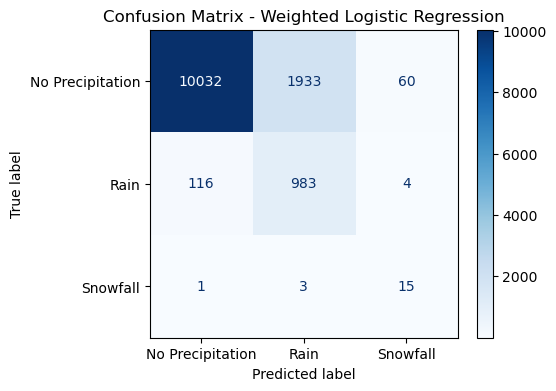

In [183]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
conf_matrix_weighted = confusion_matrix(y_test, y_pred_weighted)
fig, ax = plt.subplots(figsize=(5, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_weighted, display_labels=['No Precipitation', 'Rain', 'Snowfall'])
plot = disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
title = plt.title('Confusion Matrix - Weighted Logistic Regression')
plt.show()

Using class_weight ='balanced' argument in the algorithm, we achieved significantly better results in the minority classes, with the model now capturing 983 'rain' events out of a total of 1103 instances, and even better results in the 'snowfall' class, where it captured 15 instances. False Negative predictions (the values to the left of the main diagonal) also decreased to a very big extent where we predicted 'no precipitation' instead of the true label 'rain' only 116 times comparing to the 571 predictions in the unweighted standard approach. 

However, this improvement came at the cost of losing precision in the majority class, where the true positives in the 'no precipitation' class dropped from 11803 to 10032 and the TNs (the values to the right of the main diagonal) increased from a total of 224 (221 + 1 + 1) wrong predictions to 1997! 

This illustrates the `precision-recall trade-off` we mentioned earlier in the standard variant of the model.

- next step in evaluating the model’s performance on the test set is to compute the Precision-Recall curve for each class (No Precipitation, Rain, Snowfall) based on the model’s predicted probabilities. The precision-recall curve illustrates the trade-off between precision and recall across different probability thresholds. This metric is very important when evaluating models on heavily imbalanced datasets like ours. It shows that for the minority classes, increasing true positive predictions (recall) usually leads to a drop in precision, as false positive predictions increase. In the plot below, you can see that as recall approaches 1, precision tends to decrease towards 0, emphasizing the trade-off between these metrics.

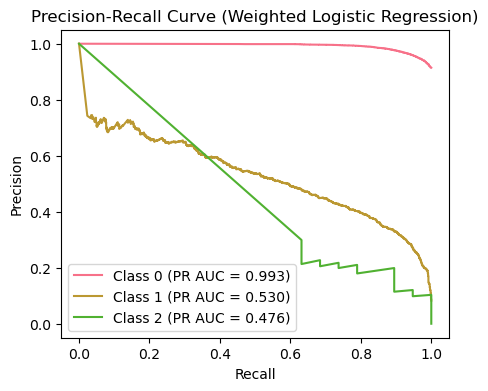

In [187]:
from sklearn.metrics import precision_recall_curve, auc
y_pred_probs_weighted = logreg_weighted.predict_proba(X_test_scaled)
figure = plt.figure(figsize=(5, 4)) 
for i in range(3):  
    precision, recall, _ = precision_recall_curve(y_test == i, y_pred_probs_weighted[:, i])
    pr_auc = auc(recall, precision)
    
    # Plot the precision-recall curve
    plot = plt.plot(recall, precision, label=f'Class {i} (PR AUC = {pr_auc:.3f})')

xlabel = plt.xlabel('Recall')
ylabel = plt.ylabel('Precision')
title = plt.title('Precision-Recall Curve (Weighted Logistic Regression)')
legend = plt.legend()
plt.savefig('Precision-Recall Curve.png')  # Save as a PNG file
plt.show()

- last step on the evaluation of the model is to create a classification report, summarizing the key metrics for each class: precision, recall, F1-score, and PR AUC (Precision-Recall Area Under the Curve). The classification report provides a detailed breakdown of these metrics for each class (No Precipitation, Rain, and Snowfall), which helps to evaluate how well the model performs for each category. Additionally, we calculate and include overall metrics such as balanced_accuracy, which is more suitable for the imbalanced nature of the dataset against the simple accuracy metric, and f1_weighted, which takes into account the number of instances in each class to give a more balanced overall F1-score. Lastly, pr_auc_weighted aggregates the PR AUC score across all classes, giving a more holistic view of the model’s performance. We transformed the report to a 1-row dataframe so as to make future comparisons with other models easier.

In [190]:
from sklearn.metrics import classification_report, balanced_accuracy_score, f1_score, average_precision_score

report_dict_weighted = classification_report(y_test, y_pred_weighted, digits=3, output_dict=True)

# Calculate PR AUC for each class
precision_0, recall_0, _ = precision_recall_curve(y_test == 0, y_pred_probs_weighted[:, 0])
pr_auc_0 = auc(recall_0, precision_0)

precision_rain, recall_rain, _ = precision_recall_curve(y_test == 1, y_pred_probs_weighted[:, 1])
pr_auc_rain = auc(recall_rain, precision_rain)

precision_snow, recall_snow, _ = precision_recall_curve(y_test == 2, y_pred_probs_weighted[:, 2])
pr_auc_snow = auc(recall_snow, precision_snow)

# Create a single row dataframe with the required metrics
report_df_weighted = pd.DataFrame({
    'precision_0': [report_dict_weighted['0']['precision']],
    'recall_0': [report_dict_weighted['0']['recall']],
    'f1_0': [report_dict_weighted['0']['f1-score']],
    'pr_auc_0': [pr_auc_0],
    
    'precision_rain': [report_dict_weighted['1']['precision']],
    'recall_rain': [report_dict_weighted['1']['recall']],
    'f1_rain': [report_dict_weighted['1']['f1-score']],
    'pr_auc_rain': [pr_auc_rain],
    
    'precision_snow': [report_dict_weighted['2']['precision']],
    'recall_snow': [report_dict_weighted['2']['recall']],
    'f1_snow': [report_dict_weighted['2']['f1-score']],
    'pr_auc_snow': [pr_auc_snow],
    'balanced_accuracy': [balanced_accuracy_score(y_test, y_pred_weighted)],
    'f1_weighted': [f1_score(y_test, y_pred_weighted, average='weighted')],
    'pr_auc_weighted': [average_precision_score(y_test, y_pred_probs_weighted, average='weighted')]
})

print('Weighted Logistic Regression')
report_df_weighted

Weighted Logistic Regression


,precision_0,recall_0,f1_0,pr_auc_0,precision_rain,recall_rain,f1_rain,pr_auc_rain,precision_snow,recall_snow,f1_snow,pr_auc_snow,balanced_accuracy,f1_weighted,pr_auc_weighted
0,0.988472,0.834262,0.904844,0.992657,0.336759,0.891206,0.488812,0.530113,0.189873,0.789474,0.306122,0.475829,0.838314,0.869074,0.952328


#### Plotting the learning curve

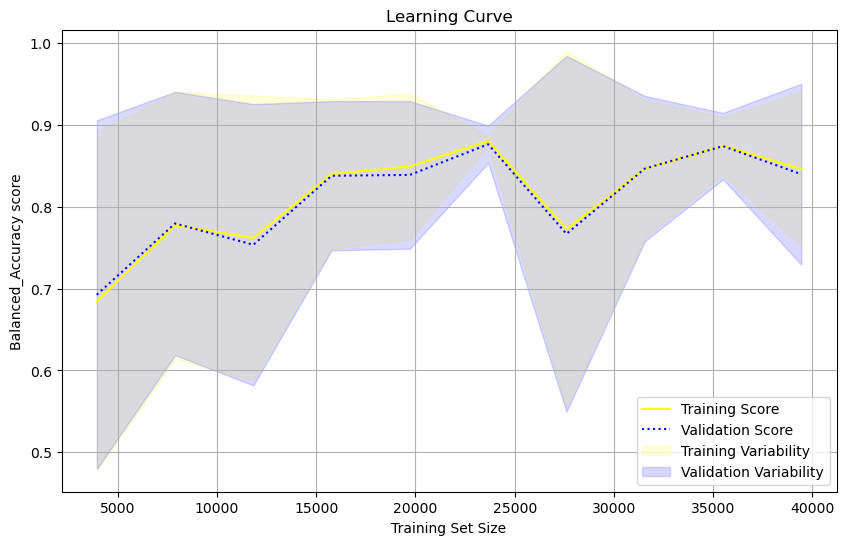

In [193]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(
    logreg_weighted, X, y, cv=stkf, scoring='balanced_accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, random_state=2024
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

figure = plt.figure(figsize=(10, 6))
plot1 = plt.plot(train_sizes, train_mean, label='Training Score', color='yellow')
plot2 = plt.plot(train_sizes, test_mean, label='Validation Score', color='blue', linestyle=':')
ce1_fill = plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='yellow', alpha=0.15, label='Training Variability')
ce2_fill = plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='blue', alpha=0.15, label='Validation Variability')

xlabel = plt.xlabel('Training Set Size')
ylabel = plt.ylabel('Balanced_Accuracy score')
titel = plt.title('Learning Curve')
legend = plt.legend(loc='lower right')
grid = plt.grid(True)
plt.show()

<u>Inferences from the Learning Curve Plot</u>   

The training and validation scores are consistently aligned across all dataset sizes, stabilizing around a balanced accuracy of 0.85 suggesting that the model is well-calibrated and does not exhibit overfitting. This close alignment, even with smaller dataset sizes, implies that applying class weights has improved the model's ability to generalize well and differentiate between classes, reducing both bias and variance.   
So this is a noticeable improvement over the baseline.
However, some fluctuations are observed at various dataset sizes, indicating that the model still faces challenges in consistently discriminating between classes. While the variance does reduce as the dataset size approaches the maximum, it remains noticeable, suggesting that the model's generalization ability varies across different validation splits. 

#### Evaluating feature importance

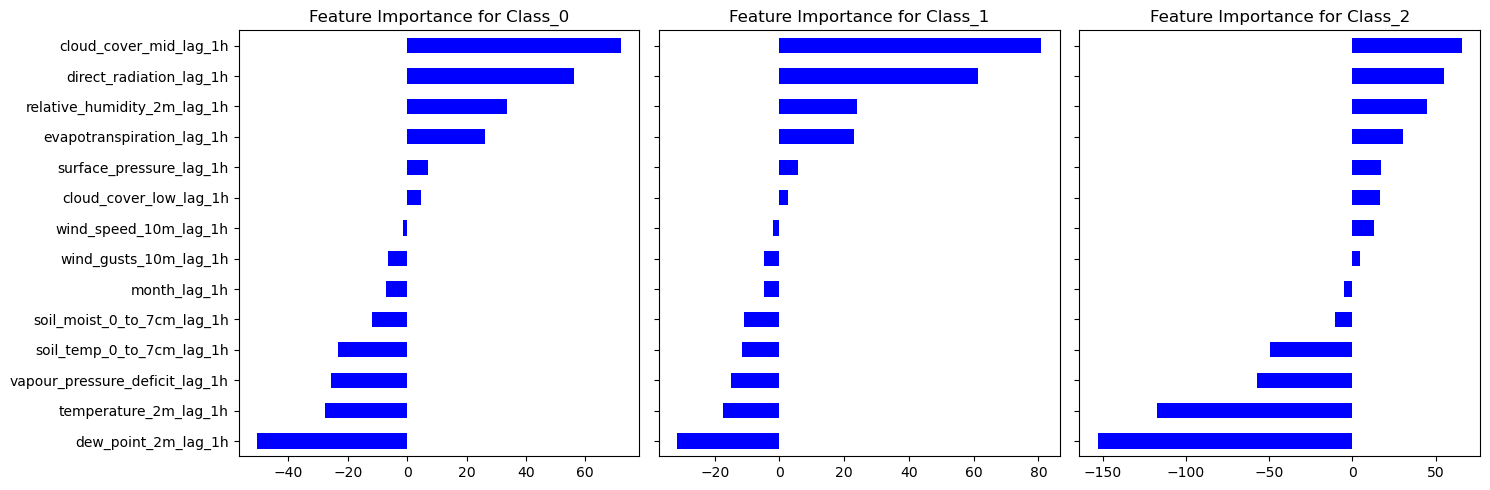

In [197]:
# Get the feature names (assuming X_train_scaled was created from weather_df without 'date' and 'weather_event')
feature_names = X.columns

# Get the coefficients for each class
coefficients = logreg_weighted.coef_

# Create a DataFrame to store coefficients for each class
coef_df = pd.DataFrame(coefficients.T, index=feature_names, columns=['Class_0', 'Class_1', 'Class_2'])

# Plot feature importance for each class
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for i, ax in enumerate(axes):
    class_name = f'Class_{i}'
    plot = coef_df[class_name].sort_values().plot(kind = 'barh', ax=ax, color = 'blue', title = f'Feature Importance for {class_name}')
    
plt.tight_layout()
plt.show()

### Logistic Regression with Oversampling using SMOTE

Moving one step further, we will attempt to mitigate the effects of the heavily imbalanced dataset via oversampling.   
Building on the model we developed earlier (Standard Logistic Regression), we will address class imbalance this time by oversampling the minority classes using the SMOTE (Synthetic Minority Over-sampling Technique) method.   
This method generates artificial records for the minority classes, increasing their representation in the training set until each class has an equal number of records.   
Once the training set is balanced, we will train the model on this newly created dataset and evaluate its performance on the original, untouched test set, which retains the original class imbalance and make the assessment unbiased.   
SMOTE is one of several oversampling methods available, details of which can be found in the official documentation here: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html.   
It utilizes the k-nearest neighbors algorithm to create synthetic records and offers several parameters that can be customized. In this project, we will use the default settings.

LogisticRegression(max_iter=5000, multi_class='multinomial', n_jobs=-1,
                   random_state=2024, solver='saga')

Execution time: 3.6577138900756836
Number of iterations: 125


[0.92587313 0.92646709 0.9246852  0.93086244 0.9212402  0.9280114
 0.92645917 0.92265712 0.92526032 0.92787461]

The mean value of balanced_accuracy on the evaluation of the train set is 0.926

The standard deviation of balanced_accuracy on the evaluation of the train set is 0.003




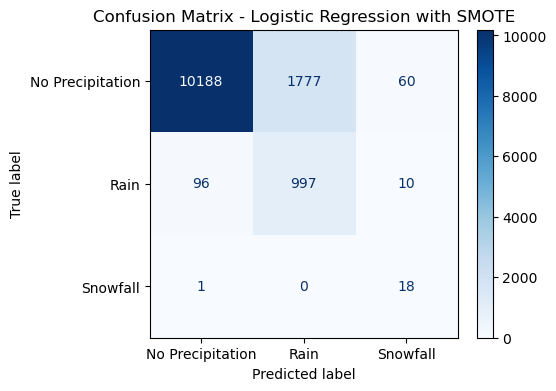

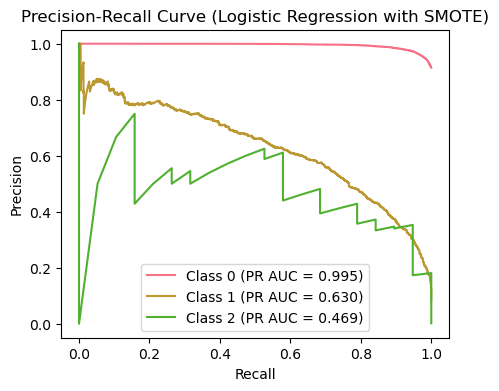

Logistic Regression with SMOTE


,precision_0,recall_0,f1_0,pr_auc_0,precision_rain,recall_rain,f1_rain,pr_auc_rain,precision_snow,recall_snow,f1_snow,pr_auc_snow,balanced_accuracy,f1_weighted,pr_auc_weighted
0,0.990569,0.847235,0.913312,0.99481,0.359409,0.903898,0.514315,0.630344,0.204545,0.947368,0.336449,0.468529,0.899501,0.879004,0.963549


In [201]:
# Import necessary libraries
from imblearn.over_sampling import SMOTE

# Define features (X) and target (y)
X = lagged_1h_df.drop(columns=['date', 'weather_event'])
y = lagged_1h_df['weather_event']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=2024)

# Standardize the features
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to the training set (to balance the classes)
smote = SMOTE(random_state=2024)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Initialize the logistic regression model for multiclass classification with SMOTE applied
logreg_smote = LogisticRegression(random_state=2024, multi_class='multinomial', solver='saga', n_jobs=-1, max_iter=5000)

start = time.time()
# Train the model on the SMOTE training data
logreg_smote.fit(X_train_smote, y_train_smote)

print(f"Execution time: {time.time() - start}")
print(f"Number of iterations: {logreg_smote.n_iter_[0]}")
print('\n')

# Predict on the true test set
y_pred_smote = logreg_smote.predict(X_test_scaled)

# Evaluate the model using cross-validation (on the SMOTE resampled training data)
stkf = StratifiedKFold(n_splits=10, shuffle=True, random_state=2024)
logreg_smote_cv = cross_val_score(logreg_smote, X_train_smote, y_train_smote, cv=stkf, scoring="balanced_accuracy", n_jobs=-1)

print(logreg_smote_cv)
print(f'\nThe mean value of balanced_accuracy on the evaluation of the train set is {logreg_smote_cv.mean().round(3)}')
print(f'\nThe standard deviation of balanced_accuracy on the evaluation of the train set is {logreg_smote_cv.std().round(3)}')
print('\n')

# Confusion Matrix
conf_matrix_smote = confusion_matrix(y_test, y_pred_smote)
fig, ax = plt.subplots(figsize=(5, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_smote, display_labels=['No Precipitation', 'Rain', 'Snowfall'])
plot = disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
title = plt.title('Confusion Matrix - Logistic Regression with SMOTE')
plt.show()

# Generate precision-recall curve for each class
y_pred_probs_smote = logreg_smote.predict_proba(X_test_scaled)
figure = plt.figure(figsize=(5, 4)) 
for i in range(3):  
    precision, recall, _ = precision_recall_curve(y_test == i, y_pred_probs_smote[:, i])
    pr_auc = auc(recall, precision)
    
    # Plot the precision-recall curve
    plot = plt.plot(recall, precision, label=f'Class {i} (PR AUC = {pr_auc:.3f})')

xlabel = plt.xlabel('Recall')
ylabel = plt.ylabel('Precision')
title = plt.title('Precision-Recall Curve (Logistic Regression with SMOTE)')
legend = plt.legend()
plt.show()

# Classification report
report_dict_smote = classification_report(y_test, y_pred_smote, digits=3, output_dict=True)

# Calculate PR AUC for each class
precision_0, recall_0, _ = precision_recall_curve(y_test == 0, y_pred_probs_smote[:, 0])
pr_auc_0 = auc(recall_0, precision_0)

precision_rain, recall_rain, _ = precision_recall_curve(y_test == 1, y_pred_probs_smote[:, 1])
pr_auc_rain = auc(recall_rain, precision_rain)

precision_snow, recall_snow, _ = precision_recall_curve(y_test == 2, y_pred_probs_smote[:, 2])
pr_auc_snow = auc(recall_snow, precision_snow)

# Create a single row dataframe with the required metrics
report_df_smote = pd.DataFrame({
    'precision_0': [report_dict_smote['0']['precision']],
    'recall_0': [report_dict_smote['0']['recall']],
    'f1_0': [report_dict_smote['0']['f1-score']],
    'pr_auc_0': [pr_auc_0],
    
    'precision_rain': [report_dict_smote['1']['precision']],
    'recall_rain': [report_dict_smote['1']['recall']],
    'f1_rain': [report_dict_smote['1']['f1-score']],
    'pr_auc_rain': [pr_auc_rain],
    
    'precision_snow': [report_dict_smote['2']['precision']],
    'recall_snow': [report_dict_smote['2']['recall']],
    'f1_snow': [report_dict_smote['2']['f1-score']],
    'pr_auc_snow': [pr_auc_snow],
    'balanced_accuracy': [balanced_accuracy_score(y_test, y_pred_smote)],
    'f1_weighted': [f1_score(y_test, y_pred_smote, average='weighted')],
    'pr_auc_weighted': [average_precision_score(y_test, y_pred_probs_smote, average='weighted')]

})

# Display the DataFrame
print('Logistic Regression with SMOTE')
report_df_smote

#### Plotting the learning curve

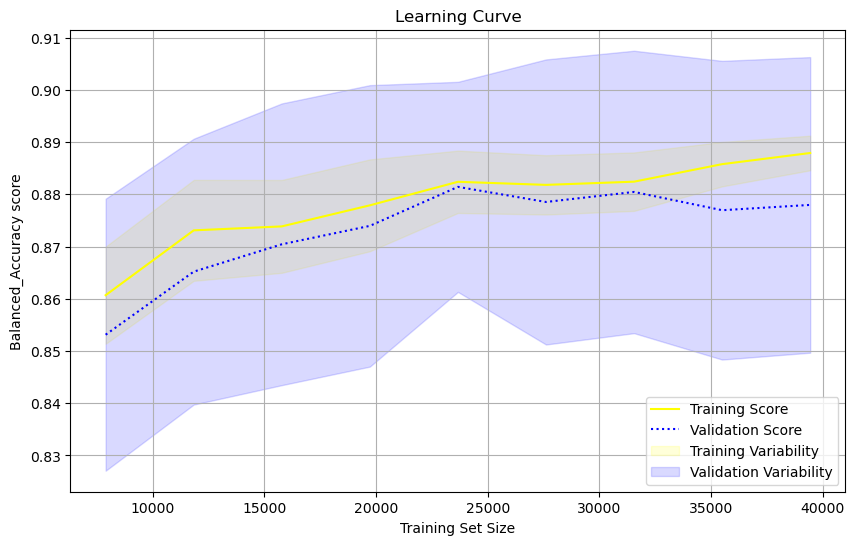

In [204]:
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline

# Create a pipeline with SMOTE and Logistic Regression
pipeline_smote = make_pipeline(SMOTE(random_state=2024), 
                               LogisticRegression(random_state=2024, multi_class='multinomial', solver='saga', max_iter=5000, tol=0.02))

# Use learning_curve with the pipeline
train_sizes, train_scores, test_scores = learning_curve(
    pipeline_smote, X, y, cv=stkf, scoring='balanced_accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, random_state=2024
)


train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

figure = plt.figure(figsize=(10, 6))
plot1 = plt.plot(train_sizes, train_mean, label='Training Score', color='yellow')
plot2 = plt.plot(train_sizes, test_mean, label='Validation Score', color='blue', linestyle=':')
ce1_fill = plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='yellow', alpha=0.15, label='Training Variability')
ce2_fill = plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='blue', alpha=0.15, label='Validation Variability')

xlabel = plt.xlabel('Training Set Size')
ylabel = plt.ylabel('Balanced_Accuracy score')
titel = plt.title('Learning Curve')
legend = plt.legend(loc='lower right')
grid = plt.grid(True)
plt.show()

<u>Inferences from the Learning Curve Plot</u>   

The oversampling technique (SMOTE) offered a model with better performance (balanced accuracy of ~0.89 on the training set and ~0.87 on the validation set), less fluctuations, but at the cost of mild overfitting and significantly higher variance on the validation/test set.
The much higher variance is probably the effect of using synthetic data to balance the classes.   

Overall, SMOTE has improved the model’s ability to differentiate between classes (lower bias), as shown by the higher balanced accuracy. However, the increased variance in validation scores and the mild overfitting are problems that need to be tackled.

#### Evaluating feature importance

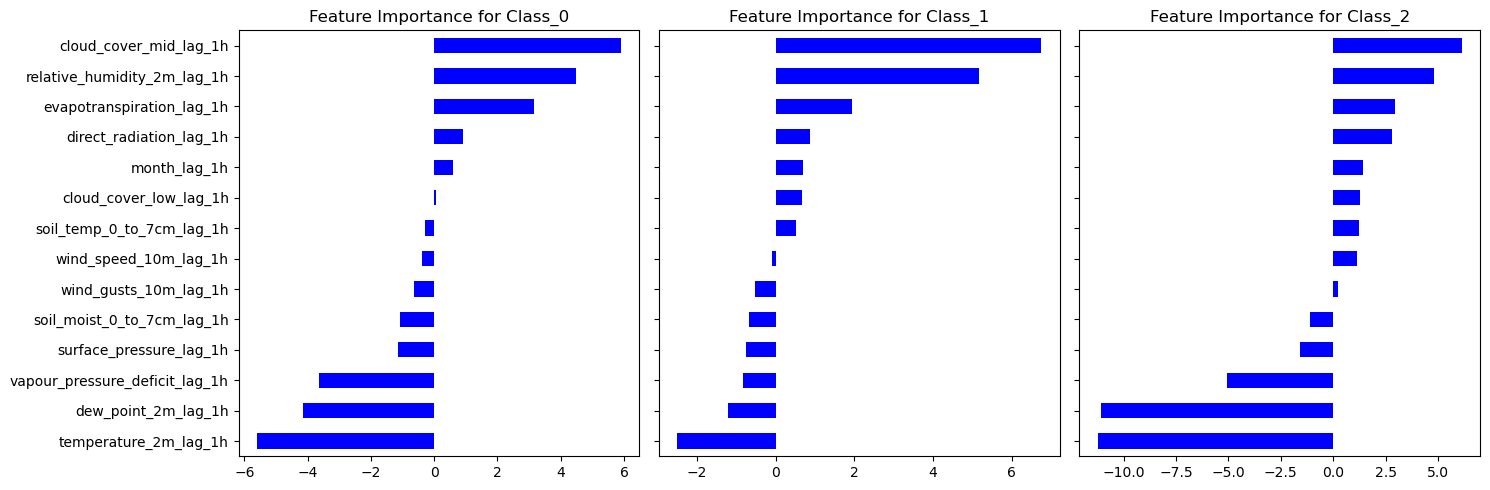

In [208]:
# Get the feature names (assuming X_train_scaled was created from weather_df without 'date' and 'weather_event')
feature_names = X.columns

# Get the coefficients for each class
coefficients = logreg_smote.coef_

# Create a DataFrame to store coefficients for each class
coef_df = pd.DataFrame(coefficients.T, index=feature_names, columns=['Class_0', 'Class_1', 'Class_2'])

# Plot feature importance for each class
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for i, ax in enumerate(axes):
    class_name = f'Class_{i}'
    plot = coef_df[class_name].sort_values().plot(kind='barh', ax=ax, title=f'Feature Importance for {class_name}', color = 'blue')
    
plt.tight_layout()
plt.show()

### One-vs-Rest (OvR) Multinomial Logistic Regression

Following the previous section where we applied an upsampling technique (SMOTE) to handle class imbalance and enhance the logistic regression model's performance, this time in the search for a possible improvement we will explore a more complex model.
This variant is the One-vs-the-Rest (OvR) strategy.   
Also known as one-vs-all, this strategy involves fitting one classifier per class, where each class is fitted against all the other classes, effectively transforming the multiclass problem into multiple binary classification problems, which in the end will be combined again to construct the final multiclass model.   

By wrapping the LogisticRegression() function inside the OvR strategy, we can build separate binary classifiers for each class and combine their predictions to perform multiclass classification. *(each binary classifier outputs a score (a probability) for its respective class, and the final prediction is made by selecting the class with the highest score(probability)).*   

While initially this seems unorthodox and naturally more computationally intensive, the goal of using this strategy is to reveal/identify patterns of the data at the binary level which might not be evident at the multi-class level and sometimes can enhance the model's ability to distinguish between classes.   

<u>Once again due to the high computational demands, we set the maximum number of iterations to 5000, although this will not be enough for the solver to converge and the model will not be fully optimized.</u>

For more information, you can refer to the  **[official documentation](https://scikit-learn.org/1.5/modules/generated/sklearn.multiclass.OneVsRestClassifier.html)**

OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                 max_iter=5000, n_jobs=-1,
                                                 random_state=2024,
                                                 solver='saga'),
                    n_jobs=-1)

Execution time: 30.666393756866455
Number of iterations for class 0: 39
Number of iterations for class 1: 37
Number of iterations for class 2: 5000


[0.91258028 0.59430512 0.88922709 0.91613718 0.84580244 0.78552638
 0.84353567 0.82639873 0.57948016 0.86851414]

The mean value of balanced_accuracy on the evaluation of the train set is 0.806

The standard deviation of balanced_accuracy on the evaluation of the train set is 0.116



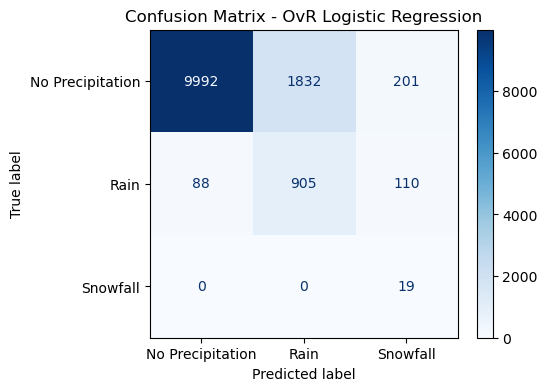

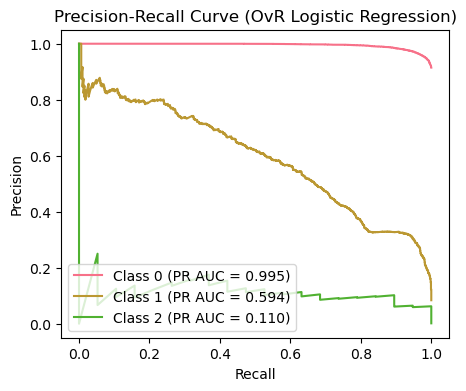

OvR Logistic Regression


,precision_0,recall_0,f1_0,pr_auc_0,precision_rain,recall_rain,f1_rain,pr_auc_rain,precision_snow,recall_snow,f1_snow,pr_auc_snow,balanced_accuracy,f1_weighted,pr_auc_weighted
0,0.99127,0.830936,0.904049,0.994909,0.330654,0.82049,0.471354,0.593725,0.057576,1.0,0.108883,0.109928,0.883808,0.866598,0.960023


In [212]:
# Define features (X) and target (y)
X = lagged_1h_df.drop(columns=['date', 'weather_event'])
y = lagged_1h_df['weather_event']

# Split data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=2024)

# Standardize the features
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the One-vs-Rest logistic regression model for multiclass classification
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

logreg_ovr = OneVsRestClassifier(LogisticRegression(random_state=2024, solver='saga', n_jobs=-1, max_iter=5000,
                                                    class_weight='balanced'), n_jobs=-1)

# Train the model
start = time.time()

logreg_ovr.fit(X_train_scaled, y_train)

print(f"Execution time: {time.time() - start}")

for idx, estimator in enumerate(logreg_ovr.estimators_):
    print(f"Number of iterations for class {idx}: {estimator.n_iter_[0]}")
    
print('\n')

# Predict on the test set
y_pred_ovr = logreg_ovr.predict(X_test_scaled)

# Evaluate the model using cross-validation (F1-weighted)
from sklearn.model_selection import StratifiedKFold, cross_val_score
stkf = StratifiedKFold(n_splits=10, shuffle=True, random_state=2024)

logreg_ovr_cv = cross_val_score(logreg_ovr, X_train_scaled, y_train, cv=stkf, scoring="balanced_accuracy", n_jobs=-1)
print(logreg_ovr_cv)
print(f'\nThe mean value of balanced_accuracy on the evaluation of the train set is {logreg_ovr_cv.mean().round(3)}')
print(f'\nThe standard deviation of balanced_accuracy on the evaluation of the train set is {logreg_ovr_cv.std().round(3)}\n')

# Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
conf_matrix_ovr = confusion_matrix(y_test, y_pred_ovr)
fig, ax = plt.subplots(figsize=(5, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_ovr, display_labels=['No Precipitation', 'Rain', 'Snowfall'])
plot = disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
title = plt.title('Confusion Matrix - OvR Logistic Regression')
plt.show()

# Generate precision-recall curve for each class (One-vs-Rest)
from sklearn.metrics import precision_recall_curve, auc
y_pred_probs_ovr = logreg_ovr.predict_proba(X_test_scaled)
figure = plt.figure(figsize=(5, 4)) 
for i in range(3):  
    precision, recall, _ = precision_recall_curve(y_test == i, y_pred_probs_ovr[:, i])
    pr_auc = auc(recall, precision)
    
    # Plot the precision-recall curve
    plot = plt.plot(recall, precision, label=f'Class {i} (PR AUC = {pr_auc:.3f})')

xlabel = plt.xlabel('Recall')
ylabel = plt.ylabel('Precision')
title = plt.title('Precision-Recall Curve (OvR Logistic Regression)')
legend = plt.legend()
plt.show()

# Classification report
from sklearn.metrics import classification_report, balanced_accuracy_score, f1_score, average_precision_score

report_dict_ovr = classification_report(y_test, y_pred_ovr, digits=3, output_dict=True)

# Calculate PR AUC for each class
precision_0, recall_0, _ = precision_recall_curve(y_test == 0, y_pred_probs_ovr[:, 0])
pr_auc_0 = auc(recall_0, precision_0)

precision_rain, recall_rain, _ = precision_recall_curve(y_test == 1, y_pred_probs_ovr[:, 1])
pr_auc_rain = auc(recall_rain, precision_rain)

precision_snow, recall_snow, _ = precision_recall_curve(y_test == 2, y_pred_probs_ovr[:, 2])
pr_auc_snow = auc(recall_snow, precision_snow)

# Create a single row dataframe with the required metrics
report_df_ovr = pd.DataFrame({
    'precision_0': [report_dict_ovr['0']['precision']],
    'recall_0': [report_dict_ovr['0']['recall']],
    'f1_0': [report_dict_ovr['0']['f1-score']],
    'pr_auc_0': [pr_auc_0],
    
    'precision_rain': [report_dict_ovr['1']['precision']],
    'recall_rain': [report_dict_ovr['1']['recall']],
    'f1_rain': [report_dict_ovr['1']['f1-score']],
    'pr_auc_rain': [pr_auc_rain],
    
    'precision_snow': [report_dict_ovr['2']['precision']],
    'recall_snow': [report_dict_ovr['2']['recall']],
    'f1_snow': [report_dict_ovr['2']['f1-score']],
    'pr_auc_snow': [pr_auc_snow],
    'balanced_accuracy': [balanced_accuracy_score(y_test, y_pred_ovr)],
    'f1_weighted': [f1_score(y_test, y_pred_ovr, average='weighted')],
    'pr_auc_weighted': [average_precision_score(y_test, y_pred_probs_ovr, average='weighted')]
})

# Display the DataFrame
print('OvR Logistic Regression')
report_df_ovr

#### Plotting the learning curve

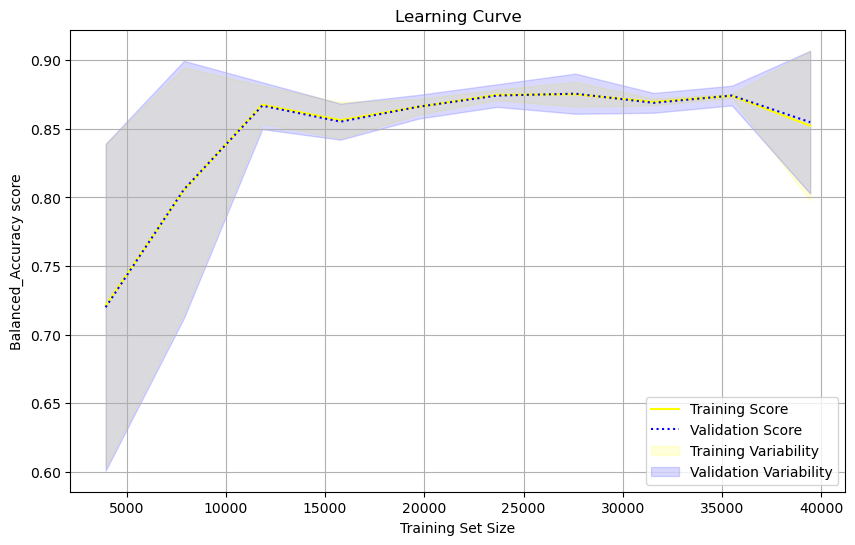

In [213]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(
    logreg_ovr, X, y, cv=stkf, scoring='balanced_accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, random_state=2024
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

figure = plt.figure(figsize=(10, 6))
plot1 = plt.plot(train_sizes, train_mean, label='Training Score', color='yellow')
plot2 = plt.plot(train_sizes, test_mean, label='Validation Score', color='blue', linestyle=':')
ce1_fill = plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='yellow', alpha=0.15, label='Training Variability')
ce2_fill = plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='blue', alpha=0.15, label='Validation Variability')

xlabel = plt.xlabel('Training Set Size')
ylabel = plt.ylabel('Balanced_Accuracy score')
title = plt.title('Learning Curve')
legend = plt.legend(loc='lower right')
grid = plt.grid(True)
plt.show()

<u>Inferences from the Learning Curve Plot</u>   

The learning curve for the One-vs-Rest logistic regression model shows a balanced accuracy of around 0.85, with the training and validation scores almost perfectly aligned, indicating minimal overfitting and excellent generalization ability.   
The low variability in both training and validation scores, along with a stable performance across dataset sizes, highlights the model’s robustness and consistency. Although the balanced accuracy reaches a plateau (around 10.000 records), suggesting limited gains from additional data, the OvR approach offers a solid, stable performance without the increased variance observed in other models like SMOTE.

#### Evaluating feature importance

If you try to evaluate the feature importance from the OvR algorithm you will end up the following error message:   
`AttributeError: 'OneVsRestClassifier' object has no attribute 'coef_'`   
This means that the object logreg_ovr is an instance of OneVsRestClassifier, and this class does not directly expose a coef_ attribute like a standard LogisticRegression model does.
Because OneVsRestClassifier wraps multiple binary classifiers (one per class), you need to access the coefficients for each binary classifier separately and thus you cannot have a total overview of the contribution of each predictor variable in the final result.   
Or in other words there is no single, unified set of coefficients that represents the contribution of each predictor to the entire multiclass model.

### Hyperparameter Optimized Logistic Regression

Up to this point, we have realized that the LogisticRegression() modeling class contains several arguments/parameters, each with multiple options from which you can choose.

In the **[official documentation](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html)**, you can find the full set of parameters like `penalty=`, `C=`, `class_weight=`, `solver=`, `max_iter=`, `multi_class=`, and `l1_ratio=`. You may have also noticed that changing even a single parameter value can significantly alter the model's performance. Is there a way to explore all available options for these parameters and their combinations? For example having 5 parameters that each can take 5 values, this will lead to a total number of 5^5 = 3125 possible combinations. Of course you can find and apply this 3125 possible combinations manually but this will take you weeks to complete.

There is a more effective way to search for all possible combinations using **[GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)**, where you manually define the parameter space, and the method will take over, creating and exploring all possible combinations for you, evaluating the model based on a specified evaluation metric, and returning the best model along with its set of optimal parameters.   
It's important to note that GridSearchCV accepts only discrete values for each parameter, defined by the user. For example, if each parameter takes 20 possible values, this will result in a very large number of combinations, making the method computationally expensive and often impractical for larger search spaces.

There is an alternative method called **[RandomizedSearchCV](https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)**, which speeds up the process by randomly selecting values from the parameter space you have defined. You specify how many combinations should be evaluated by setting the `n_iter` argument. The method evaluates these combinations and returns the best model along with its corresponding parameters. This approach significantly reduces the computational time but does not guarantee that it will find the absolute best model, given the dataset and parameter space at hand.

In this section, we will use another method called **[BayesSearchCV](https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html)**, which performs Bayesian optimization. This method intelligently searches the hyperparameter space using a probabilistic model to guide the search, making it more efficient than traditional methods like GridSearchCV and RandomizedSearchCV.

The process begins by defining the hyperparameter search space. Initially, BayesSearchCV performs a small number of random evaluations by selecting different combinations of hyperparameters. These initial evaluations explore diverse regions of the parameter space to gather data. Based on this data, the algorithm builds a probabilistic model, which helps predict which areas of the hyperparameter space are most likely to contain optimal combinations.

This approach significantly reduces the number of hyperparameter combinations that need to be evaluated, making it much more efficient. The best model and its optimal hyperparameter settings are returned after evaluating all combinations.
Even though this method is much more efficient, there’s a degree of randomness in the cross-validation process and in the initial random samples selected during the BayesSearchCV process. This might cause optimization to focus on suboptimal areas of the hyperparameter space and it does not guarantee that you will indeed end up with the best possible model settings. An increase on the n_iter argument (the number of parameter combinations) can help in this direction but it will also increase the computational cost. Experience also will be valuable since you can restrict the hyperparameter space if you already know where the best possible combination might lie and this can be set by defining the prior distribution in the prior argument of each parameter you aim.

<u>Key points on BayesSearchCV</u>
- The n_iter argument is specified by the user when calling BayesSearchCV(). After setting this parameter, the user no longer controls how the algorithm selects combinations within the search space. For example, if n_iter=30, the algorithm will evaluate 30 different hyperparameter combinations in total. Initially, a small number of combinations are randomly selected and evaluated. Based on these initial evaluations, the algorithm builds a probabilistic model, which it then uses to guide the remaining iterations, focusing on combinations that are predicted to yield better performance. The best model from all 30 evaluations is returned as the final model.
- Increasing the n_iter argument, increases your chances of finding the best possible model, but at the same time you are also increasing your computational costs (time and resources)
- Initially, BayesSearchCV performs a few random evaluations of hyperparameter combinations (the rest combinations will be used after the probabilistic model is build). These initial samples are influenced by the **`prior`** distribution that we define for each parameter (e.g., `log-uniform` for `C`). The prior distribution represents our **initial belief** about where the best hyperparameters might lie.
- In this phase, random hyperparameter values are sampled from the defined search space, but the **`prior`** (e.g., `log-uniform`) influences the frequency with which different values are selected. For example, if you're using 'log-uniform' for 'C', smaller values (closer to 0.1) will be sampled more often than larger values, because this is your initial/prior belief of where the best parameters might lie.
- If your initial guess/belief about the prior distribution for sampling values is incorrect, don't worry. This will be reflected in the probabilistic model built by the algorithm, based on the poor performance of the models built using that prior. These poor results will prompt the algorithm to adapt, and guide the search towards more promising ranges. Therefore, it is the range of the parameter values that you should be careful not to restrict. An incorrect initial prior probability will not prevent the algorithm from finding good solutions, as it will adjust during the search.
- After evaluating the initial random samples, BayesSearchCV builds a **probabilistic model**. This model then uses the updated probabilities distribution (*posterior distribution*), which is the updated belief about where the best hyperparameters might lie after incorporating the results of the initial evaluations.
- From this point, the **posterior distribution** is used to guide the search. The algorithm no longer selects hyperparameters randomly; instead, it uses the posterior distribution to focus the search on areas of the hyperparameter space that are predicted to perform better.

**Last important note**   
While BayesSearchCV is more effective than traditional methods at exploring and exploiting the hyperparameter space, it still cannot guarantee the optimal set of parameters—and thus the best possible model-, <u>**due to its probabilistic nature**.</u>   
Additionally, while BayesSearchCV is more effective, choosing a large number of possible parameter combinations (via the n_iter argument, e.g., 100), setting a high maximum number of iterations for the selected solver to minimize the loss function and converge (via the max_iter argument, e.g., 100.000) and the tolerance to smaller values like tol=0.001, can lead to significantly increased computational costs, potentially taking several hours to return a result.   
*(The tol parameter controls the minimum improvement required in the loss function between iterations. If the improvement in the loss function between two consecutive iterations drops below 0.001, the solver stops the optimization process and is considered to have converged)*

<u>Due to computational limitations, we will implement BayesSearchCV with a reduced number of hyperparameter combinations (n_iter=20) and set max_iter argument to 150. Additionally, we will enable warm_start=True, allowing the model to reuse the coefficients from previous iterations to speed up the process. However using these optons the algorithm will not converge.</u>   
While these adjustments limit significantly our ability to fully explore the best possible model, we will proceed with the implementation for demonstration reasons.

Before running the script below, ensure that you have run the following:   
`pip install --upgrade pip`   
`pip install scikit-optimize`

In [223]:
# Define features (X) and target (y)
X = lagged_1h_df.drop(columns=['date', 'weather_event'])
y = lagged_1h_df['weather_event']

# Split data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=2024)

# Standardize the features
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [225]:
import time
start = time.time()

from sklearn.model_selection import StratifiedKFold
stkf = StratifiedKFold(n_splits=10, shuffle=True, random_state=2024)

from skopt import BayesSearchCV
from skopt.space import Real, Categorical
from sklearn.linear_model import LogisticRegression

# Define the parameter search space
param_space = [
    {
        'C': Real(0.1, 100, prior='log-uniform'),  # Regularization strength
        'penalty': Categorical(['l2']),  
        'solver': Categorical(['saga'])  
    },
    {
        'C': Real(0.1, 100, prior='log-uniform'),  # Regularization strength
        'penalty': Categorical(['l1']),  
        'solver': Categorical(['saga'])  
    },
    {
        'C': Real(0.1, 100, prior='log-uniform'),  # Regularization strength
        'penalty': Categorical(['elasticnet']),  
        'solver': Categorical(['saga']),  
        'l1_ratio': Real(0, 1)  # Balance between L1 and L2 regularization
    }
]

# Initialize BayesSearchCV
bayes_search = BayesSearchCV(estimator=LogisticRegression(class_weight='balanced', max_iter=150, 
                                                          warm_start=True, random_state=2024, n_jobs=-1),
                             search_spaces=param_space,
                             n_iter=20,  
                             scoring='balanced_accuracy',
                             cv=stkf,
                             random_state=2024,
                             n_jobs=-1)

# Fit to your training data
bayes_search.fit(X_train_scaled, y_train)

# Output the best parameters
print("Best parameters found: ", bayes_search.best_params_)
print("Best cross-validation score: ", bayes_search.best_score_)

print('\n')
print(f"Execution time: {time.time() - start}")
print('\n')

# Extracting the mean and standard deviation of the cross-validation scores
means = bayes_search.cv_results_['mean_test_score']
stds = bayes_search.cv_results_['std_test_score']

print("Mean cross-validation scores for all parameters: ", means)
print("Std cross-validation scores for all parameters: ", stds)

# Output detailed information about each iteration
results_df = pd.DataFrame(bayes_search.cv_results_)
results_df

C:\Users\papak\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


BayesSearchCV(cv=StratifiedKFold(n_splits=10, random_state=2024, shuffle=True),
              estimator=LogisticRegression(class_weight='balanced',
                                           max_iter=150, n_jobs=-1,
                                           random_state=2024, warm_start=True),
              n_iter=20, n_jobs=-1, random_state=2024,
              scoring='balanced_accuracy',
              search_spaces=[{'C': Real(low=0.1, high=100, prior='log-uniform', transform='normalize'),
                              'penalty': C...
                              'penalty': Categorical(categories=('l1',), prior=None),
                              'solver': Categorical(categories=('saga',), prior=None)},
                             {'C': Real(low=0.1, high=100, prior='log-uniform', transform='normalize'),
                              'l1_ratio': Real(low=0, high=1, prior='uniform', transform='normalize'),
                              'penalty': Categorical(categories=('elasticnet',), prior=None),
                              'solver': Categorical(categories=('saga',), prior=None)}])

Best parameters found:  OrderedDict({'C': 33.60117529901964, 'penalty': 'l2', 'solver': 'saga'})
Best cross-validation score:  0.9049320333077763


Execution time: 220.07296919822693


Mean cross-validation scores for all parameters:  [0.89188092 0.90493203 0.88026048 0.89394759 0.82290839 0.84114218
 0.88035032 0.83087212 0.89893457 0.90241114 0.80470199 0.88021526
 0.88403079 0.83211297 0.87842426 0.88046806 0.89306998 0.77713045
 0.85368695 0.84090725 0.88528466 0.86970894 0.88243438 0.8844548
 0.81969693 0.88833001 0.89503033 0.87812457 0.87111319 0.82418001
 0.80438484 0.89503033 0.89500657 0.88221243 0.88810963 0.88733852
 0.8965918  0.88762084 0.89727851 0.84646742 0.89357772 0.89740233
 0.90161624 0.89503637 0.85464312 0.89504488 0.87723403 0.87504798
 0.88743098 0.90113214 0.81787045 0.79297073 0.86653466 0.88762088
 0.89016223 0.78486433 0.84187386 0.89551778 0.7971426  0.87967137]
Std cross-validation scores for all parameters:  [0.03256747 0.00890431 0.05403895 0.02195794 0

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,param_l1_ratio,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,2.108921,0.145737,0.001423,0.001433,2.731082,l2,saga,NaN,"{'C': 2.7310818913316273, 'penalty...",0.920985,...,0.896275,0.891235,0.905097,0.798218,0.910008,0.898498,0.895990,0.891881,0.032567,18
1,2.366793,0.119631,0.001481,0.001127,33.601175,l2,saga,NaN,"{'C': 33.60117529901964, 'penalty'...",0.914941,...,0.914532,0.916266,0.898384,0.886543,0.904971,0.896255,0.904215,0.904932,0.008904,1
2,2.351782,0.101754,0.002161,0.000507,24.266765,l2,saga,NaN,"{'C': 24.26676478459165, 'penalty'...",0.915684,...,0.923325,0.897247,0.906731,0.731007,0.840653,0.888613,0.895173,0.880260,0.054039,33
3,2.336007,0.128821,0.002016,0.000741,23.019604,l2,saga,NaN,"{'C': 23.01960352516683, 'penalty'...",0.915654,...,0.835783,0.903089,0.918365,0.886701,0.901337,0.884499,0.892766,0.893948,0.021958,15
4,2.331812,0.117248,0.002119,0.000647,7.265894,l2,saga,NaN,"{'C': 7.265893613326244, 'penalty'...",0.918935,...,0.476879,0.877760,0.906137,0.887346,0.699534,0.877381,0.774612,0.822908,0.133122,52
5,2.339299,0.109130,0.002124,0.000664,4.948789,l2,saga,NaN,"{'C': 4.948789098913576, 'penalty'...",0.909193,...,0.491253,0.890602,0.893770,0.897256,0.830085,0.902109,0.894549,0.841142,0.122003,47
6,2.035881,0.085921,0.002243,0.000344,0.203661,l2,saga,NaN,"{'C': 0.20366101378329934, 'penalt...",0.897447,...,0.896760,0.878950,0.879692,0.850494,0.859754,0.882729,0.879950,0.880350,0.014311,32
7,2.077840,0.087018,0.001974,0.000355,0.294646,l2,saga,NaN,"{'C': 0.2946458097821532, 'penalty...",0.895650,...,0.905046,0.869493,0.853824,0.844760,0.860528,0.876059,0.840444,0.830872,0.112960,50
8,2.361828,0.136918,0.002061,0.000650,85.015491,l2,saga,NaN,"{'C': 85.01549072230182, 'penalty'...",0.899290,...,0.925759,0.876041,0.912503,0.897138,0.908988,0.900028,0.865885,0.898935,0.016274,5
9,2.349379,0.130343,0.002353,0.000651,40.980856,l2,saga,NaN,"{'C': 40.98085568162423, 'penalty'...",0.907099,...,0.915383,0.895763,0.898195,0.893802,0.901186,0.900298,0.913289,0.902411,0.006849,2


In [227]:
bayes_best_model = bayes_search.best_estimator_
y_pred_bayes_grid = bayes_best_model.predict(X_test_scaled)

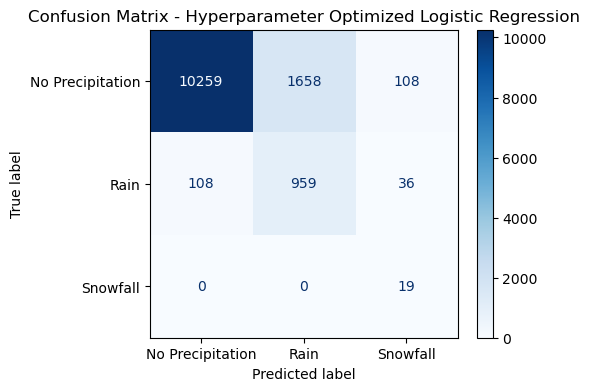

In [229]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
fig, ax = plt.subplots(figsize=(5, 4))
conf_matrix_bayes_grid = confusion_matrix(y_test, y_pred_bayes_grid)
disp = ConfusionMatrixDisplay(conf_matrix_bayes_grid, display_labels=['No Precipitation', 'Rain', 'Snowfall'])
plot = disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
title = plt.title('Confusion Matrix - Hyperparameter Optimized Logistic Regression')
plt.show()

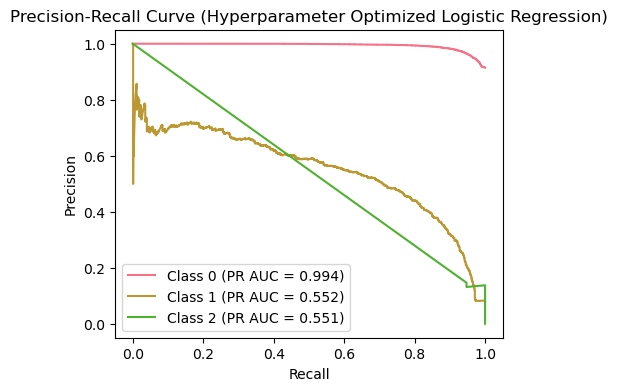

In [231]:
# Generate precision-recall curve for each class
# Classification report
from sklearn.metrics import classification_report, balanced_accuracy_score, f1_score, average_precision_score, precision_recall_curve, auc

y_pred_probs_bayes_grid = bayes_best_model.predict_proba(X_test_scaled)
figure = plt.figure(figsize=(5, 4)) 
for i in range(3):  
    precision, recall, _ = precision_recall_curve(y_test == i, y_pred_probs_bayes_grid[:, i])
    pr_auc = auc(recall, precision)
    
    # Plot the precision-recall curve
    plot = plt.plot(recall, precision, label=f'Class {i} (PR AUC = {pr_auc:.3f})')

xlabel = plt.xlabel('Recall')
ylabel = plt.ylabel('Precision')
title = plt.title('Precision-Recall Curve (Hyperparameter Optimized Logistic Regression)')
legend = plt.legend()
plt.show()

In [233]:
# Classification report
report_dict_grid = classification_report(y_test, y_pred_bayes_grid, digits=3, output_dict=True)

# Calculate PR AUC for each class
precision_0, recall_0, _ = precision_recall_curve(y_test == 0, y_pred_probs_bayes_grid[:, 0])
pr_auc_0 = auc(recall_0, precision_0)

precision_rain, recall_rain, _ = precision_recall_curve(y_test == 1, y_pred_probs_bayes_grid[:, 1])
pr_auc_rain = auc(recall_rain, precision_rain)

precision_snow, recall_snow, _ = precision_recall_curve(y_test == 2, y_pred_probs_bayes_grid[:, 2])
pr_auc_snow = auc(recall_snow, precision_snow)
# Create a single row dataframe with the required metrics
report_df_bayes_grid = pd.DataFrame({
    'precision_0': [report_dict_grid['0']['precision']],
    'recall_0': [report_dict_grid['0']['recall']],
    'f1_0': [report_dict_grid['0']['f1-score']],
    'pr_auc_0': [pr_auc_0],
    
    'precision_rain': [report_dict_grid['1']['precision']],
    'recall_rain': [report_dict_grid['1']['recall']],
    'f1_rain': [report_dict_grid['1']['f1-score']],
    'pr_auc_rain': [pr_auc_rain],
    
    'precision_snow': [report_dict_grid['2']['precision']],
    'recall_snow': [report_dict_grid['2']['recall']],
    'f1_snow': [report_dict_grid['2']['f1-score']],
    'pr_auc_snow': [pr_auc_snow],
    'balanced_accuracy': [balanced_accuracy_score(y_test, y_pred_bayes_grid)],
    'f1_weighted': [f1_score(y_test, y_pred_bayes_grid, average='weighted')],
    'pr_auc_weighted': [average_precision_score(y_test, y_pred_probs_bayes_grid, average='weighted')]

})

# Display the DataFrame
print('Hyperparameter Optimized Logistic Regression')
report_df_bayes_grid

Hyperparameter Optimized Logistic Regression


,precision_0,recall_0,f1_0,pr_auc_0,precision_rain,recall_rain,f1_rain,pr_auc_rain,precision_snow,recall_snow,f1_snow,pr_auc_snow,balanced_accuracy,f1_weighted,pr_auc_weighted
0,0.989582,0.853139,0.916309,0.993803,0.36645,0.869447,0.515591,0.552333,0.116564,1.0,0.208791,0.550705,0.907529,0.881668,0.955596


#### Plotting the learning curve

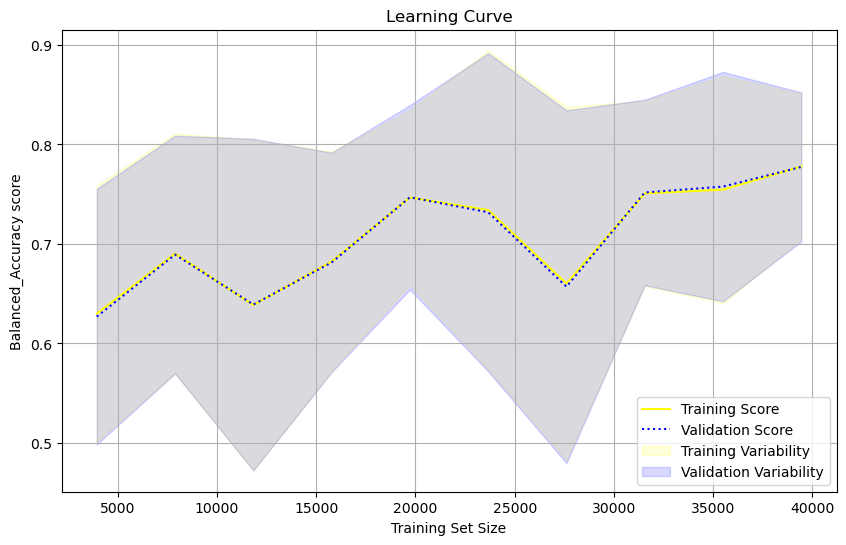

In [235]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(
    bayes_best_model, X, y, cv=stkf, scoring='balanced_accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, random_state=2024
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

figure = plt.figure(figsize=(10, 6))
plot1 = plt.plot(train_sizes, train_mean, label='Training Score', color='yellow')
plot2 = plt.plot(train_sizes, test_mean, label='Validation Score', color='blue', linestyle=':')
ce1_fill = plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='yellow', alpha=0.15, label='Training Variability')
ce2_fill = plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='blue', alpha=0.15, label='Validation Variability')

xlabel = plt.xlabel('Training Set Size')
ylabel = plt.ylabel('Balanced_Accuracy score')
titel = plt.title('Learning Curve')
legend = plt.legend(loc='lower right')
grid = plt.grid(True)
plt.show()

<u>Inferences from the Learning Curve Plot</u>   

The learning curve for the Bayes Grid Search logistic regression model shows balanced accuracy scores stabilizing around 0.78, with closely aligned training and validation scores, indicating minimal overfitting and decent generalization.   
However, the moderate accuracy suggests that the model still exhibits a degree of bias, meaning it may not fully capture complex patterns within the data. 

The wide variability observed in both training and validation scores, suggests that these parameters may not consistently generalize across all subsets. The fluctuations in balanced accuracy, along with the high variance in the validation set, highlight that the model’s performance is not satisfactory.

The computational constraints, limit us from reaching a fully optimized model and probably this is the reason for the current bias and high variance that the model demonstrates. Given these limitations, we were not able to reach an optimal configuration that could reduce bias and variance and therefore additional conclusions should be drawn with caution.

#### Evaluating feature importance

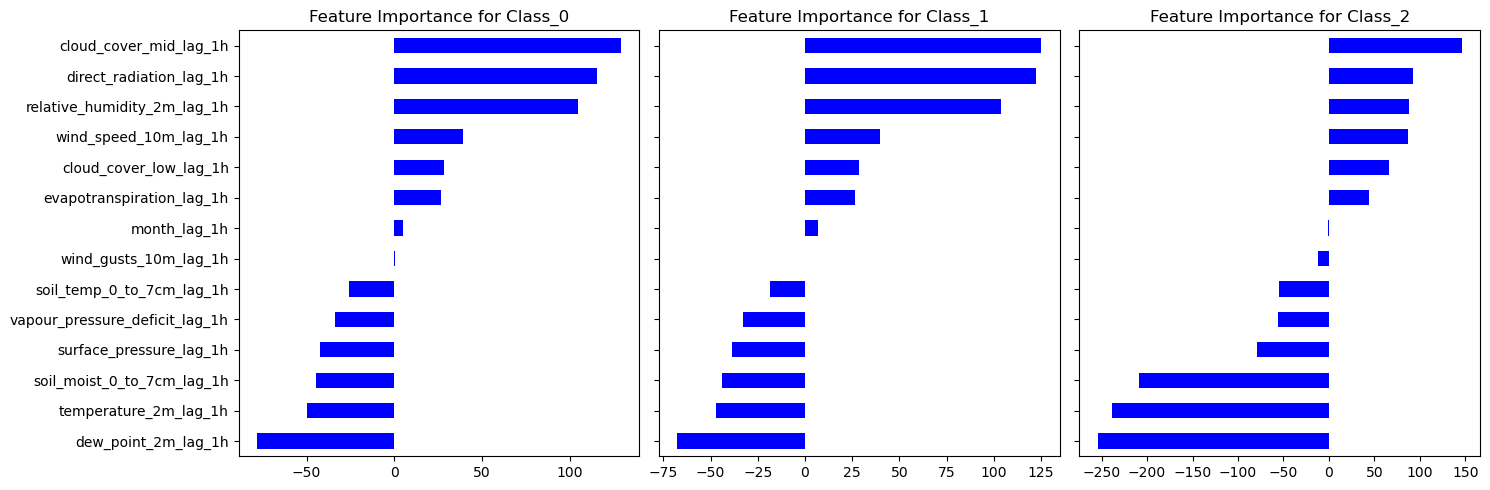

In [239]:
# Get the feature names (assuming X_train_scaled was created from weather_df without 'date' and 'weather_event')
feature_names = X.columns

# Get the coefficients for each class
coefficients = bayes_best_model.coef_

# Create a DataFrame to store coefficients for each class
coef_df = pd.DataFrame(coefficients.T, index=feature_names, columns=['Class_0', 'Class_1', 'Class_2'])

# Plot feature importance for each class
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for i, ax in enumerate(axes):
    class_name = f'Class_{i}'
    plot = coef_df[class_name].sort_values().plot(kind='barh', ax=ax, title=f'Feature Importance for {class_name}', color = 'blue')
    
plt.tight_layout()
plt.show()

### Model comparison

In [242]:
comparison_df = pd.concat(
    [report_df_standard, report_df_weighted, report_df_smote, report_df_ovr, report_df_bayes_grid], 
    axis=0
)
comparison_df.index = ['Standard Logreg', 'Weighted', 'SMOTE', 'OvR', 'Grid']

In [244]:
comparison_df

,precision_0,recall_0,f1_0,pr_auc_0,precision_rain,recall_rain,f1_rain,pr_auc_rain,precision_snow,recall_snow,f1_snow,pr_auc_snow,balanced_accuracy,f1_weighted,pr_auc_weighted
Standard Logreg,0.953085,0.981538,0.967102,0.994943,0.703311,0.481414,0.571582,0.653215,0.750000,0.315789,0.444444,0.628211,0.592914,0.933164,0.965786
Weighted,0.988472,0.834262,0.904844,0.992657,0.336759,0.891206,0.488812,0.530113,0.189873,0.789474,0.306122,0.475829,0.838314,0.869074,0.952328
SMOTE,0.990569,0.847235,0.913312,0.994810,0.359409,0.903898,0.514315,0.630344,0.204545,0.947368,0.336449,0.468529,0.899501,0.879004,0.963549
OvR,0.991270,0.830936,0.904049,0.994909,0.330654,0.820490,0.471354,0.593725,0.057576,1.000000,0.108883,0.109928,0.883808,0.866598,0.960023
Grid,0.989582,0.853139,0.916309,0.993803,0.366450,0.869447,0.515591,0.552333,0.116564,1.000000,0.208791,0.550705,0.907529,0.881668,0.955596


A comparison between the methods applied in this project should be performed with caution, since we were unable to fully optimize the models due to computational constraints (in none of the models did the solver for the loss function converged).   
A comparison DataFrame was generated for the records.

In terms of performance the differences are minor, and in several measures, you must search to the second decimal place to find them.

Given the heavily imbalanced dataset, all methods struggled to balance precision and recall, leading to a common trade-off: increasing true positives (TPs) also raised false positives (FPs), illustrating the inherent challenges of working with imbalanced data.

A practical approach for evaluating models performance would be to plot all the confusion matrices side by side and compare the TPs, FPs and so on, model by model.

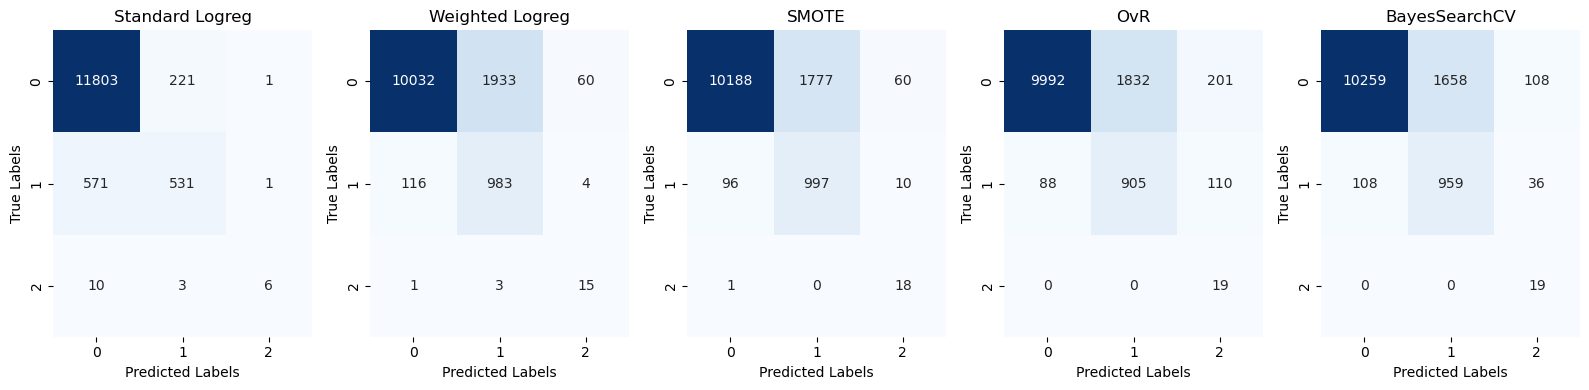

In [247]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# List of confusion matrices and method names
confusion_matrices = [conf_matrix_standard, conf_matrix_weighted, conf_matrix_smote, conf_matrix_ovr, conf_matrix_bayes_grid]
method_names = ['Standard Logreg', 'Weighted Logreg', 'SMOTE', 'OvR', 'BayesSearchCV']

# Plot confusion matrices side by side
fig, axes = plt.subplots(1, len(confusion_matrices), figsize=(16, 4))

for i, ax in enumerate(axes.flat):
    map = sns.heatmap(confusion_matrices[i], annot=True, fmt="d", cmap="Blues", ax=ax, cbar=False)
    title =ax.set_title(method_names[i])
    xlabel = ax.set_xlabel('Predicted Labels')
    ylabel = ax.set_ylabel('True Labels')

plt.tight_layout()
plt.show()

In Standard Logistic Regression not addressing class imbalance led to biased results in favor of the majority class (no precipitation) where the model predicted around 1500 to 1800 more instances of 'no precipitation' compared to the other methods.   
This bias in favor of the majority is also the reason of producing significantly more false negatives (FNs) compared to the other methods. (571 FNs for 'rain' events and 10 for 'snowfall' events.

All other approaches handled class imbalance more effectively, with the oversampling (SMOTE) approach capturing the most TPs instances for the 'rain' class, but missed one instance for the 'snowfall' class, which the OvR and BayesSearchGrid approaches were able to capture.
With respect to the balanced accuracy metric, BayesSearchGrid method achieved slightly better performance than the other models, despite being severely constrained (significantly fewer iterations -150 vs 5000- for the solver of the loss function).

Given these results, my choice would be the OvR method.   
Although it did not achieve the best balanced accuracy (though the difference is small), most importantly it demonstrated the lowest variance with minimal if not zero overfitting signs. 

<u>Closing we should mention one more time that **all methods were not fully optimized due to computational constraints**, and the full picture if we had the ability to fully optimize them could be different. </u>

### Final Thoughts

Machine Learning projects in real life conclude with actionable insights, recommendations, or real-world applications.    
However, this is not the case in this project where the primary purpose was to explore and practice various classification algorithms, such as Logistic Regression in this notebook, and their ability to handle heavily imbalanced datasets which is the most usual case in real life scenarios and present the biggest challenge.

Drawing conclusions like "increases in relative humidity and evapotranspiration increase the likelihood of rain, or decreases in temperature and dew point increase the likelihood of rain or snowfall" would be pointless in the context of this project. These models, given their simplicity and the limitations of the dataset (use of only historical data), are not designed to be used for accurate, real-life weather forecasting.   

In subsequent notebooks, we will explore more advanced algorithms such as Random Forests, Support Vector Machines (SVM), and Neural Networks to evaluate whether they can handle this classification task more effectively, especially with respect to handling class imbalance and improving predictive accuracy.   
I hope you find this notebook helpful.